#Carlos Alfredo Percca Anchapuri
GITHUB : https://github.com/CarlosPercca/ESIS-IA-LAB4B.git
# 4b. Despliegue de su modelo
Ahora que tenemos un modelo bien entrenado, es hora de utilizarlo. En este ejercicio, expondremos nuevas imágenes a nuestro modelo y detectaremos las letras correctas del alfabeto del lenguaje de signos. ¡Vamos a empezar!

## 4b.1 Objetivos

* Cargar desde disco un modelo ya entrenado
* Reformatear imágenes para un modelo entrenado con imágenes de formato diferente.
* Realizar inferencias con imágenes nuevas, nunca vistas por el modelo entrenado y evaluar su rendimiento.

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.io as tv_io
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 4b.2 Cargando el Modelo

Ahora que estamos en un nuevo cuaderno, vamos a cargar el modelo guardado que hemos entrenado. Nuestro guardado del ejercicio anterior creó una carpeta llamada «asl_model». Podemos cargar el modelo seleccionando la misma carpeta.

Dado que nuestro modelo utiliza un [módulo personalizado](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html), necesitaremos cargar el código de esa clase. Hemos guardado una copia del código en [utils.py](./uitls.py).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install -y p7zip-full
!wget https://github.com/CarlosPercca/ESIS-IA-LAB4B/raw/main/MNIST.7z -O MNIST.7Z
!7z x MNIST.7Z
!rm -f MNIST.7Z

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
--2025-05-01 00:15:33--  https://github.com/CarlosPercca/ESIS-IA-LAB4B/raw/main/MNIST.7z
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CarlosPercca/ESIS-IA-LAB4B/main/MNIST.7z [following]
--2025-05-01 00:15:34--  https://raw.githubusercontent.com/CarlosPercca/ESIS-IA-LAB4B/main/MNIST.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1679852 (1.6M) [application/octet-stream]
Savi

In [ ]:
from utils import MyConvBlock

Ahora que tenemos una definición para `MyConvBlock`, podemos usar [torch.load](https://pytorch.org/docs/stable/generated/torch.load.html) para cargar un modelo desde una ruta. Podemos usar `map_location` para especificar el dispositivo. Cuando imprimimos el modelo, ¿se ve igual que en el último cuaderno?

In [ ]:
model = torch.load('model.pth', map_location=device, weights_only=False)
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=675, out_features=512, bias=True)
    (15): Dropout

También podemos verificar si el modelo está en nuestra GPU.

In [ ]:
next(model.parameters()).device

device(type='cuda', index=0)

## 4b.3 Preparar una imagen para el modelo

Ahora es el momento de utilizar el modelo para hacer predicciones sobre nuevas imágenes que nunca ha visto antes. Esto también se llama inferencia. Tenemos un conjunto de imágenes en la carpeta `data/asl_images`. Intenta abrirla utilizando el navegador de la izquierda y explora las imágenes.

Te darás cuenta de que las imágenes que tenemos son de mucha mayor resolución que las imágenes de nuestro conjunto de datos. También son en color. Recuerda que nuestras imágenes en el conjunto de datos eran de 28x28 píxeles y en escala de grises. Es importante tener en cuenta que siempre que hacemos predicciones con un modelo, la entrada debe coincidir con la forma de los datos con los que se entrenó el modelo. Para este modelo, el conjunto de datos de entrenamiento tenía la forma: (27455, 28, 28, 1). Esto correspondía a 27455 imágenes de 28 por 28 píxeles cada una con un canal de color (escala de grises).

### 4b.3.1 Mostrar las imágenes

Cuando utilicemos nuestro modelo para hacer predicciones sobre nuevas imágenes, será útil mostrar también la imagen. Para ello, podemos utilizar la biblioteca matplotlib.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

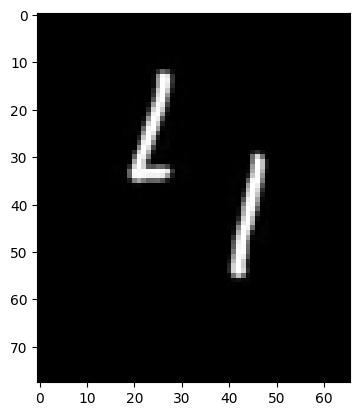

In [ ]:
show_image('/content/test/blot/4.png')

### 4b.3.2 Escalado de las imágenes

Las imágenes de nuestro conjunto de datos eran de 28x28 píxeles y en escala de grises. Necesitamos asegurarnos de pasar el mismo tamaño e imágenes en escala de grises a nuestro método para la predicción. Hay algunas formas de editar imágenes con Python, pero TorchVision también tiene la función [read_image](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html). Podemos hacerle saber qué tipo de imagen leer con [ImageReadMode](https://pytorch.org/vision/stable/generated/torchvision.io.ImageReadMode.html#torchvision.io.ImageReadMode).

In [ ]:
image = tv_io.read_image('/content/test/blot/1.png', tv_io.ImageReadMode.GRAY)
image

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

Fijémonos en la forma de la imagen.

In [ ]:
image.shape

torch.Size([1, 78, 80])

Esta imagen es mucho más grande que con la que entrenamos. Podemos utilizar [TorchVision](https://pytorch.org/vision/stable/index.html)'s [Transforms](https://pytorch.org/vision/0.9/transforms.html) de nuevo para obtener los datos en la forma que nuestro modelo espera.

Lo haremos:
* Convertiremos la imagen a float con [ToDtype](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToDtype.html)
  * Estableceremos `scale` a `True` para convertir de [0, 255] a [0, 1].
* [Redimensionar](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Resize.html#torchvision.transforms.v2.Resize) la imagen para que sea de 28 x 28 píxeles
* Convertir las imágenes a [Escala de grises](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Grayscale.html#torchvision.transforms.v2.Grayscale)
  * Este paso no hace nada ya que nuestros modelos ya están en escala de grises, pero lo hemos añadido aquí para mostrar una forma alternativa de obtener imágenes en escala de grises.

In [ ]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()  # From Color to Gray
])

Probemos `preprocess_trans` en una imagen para asegurarnos de que funciona correctamente:

In [ ]:
processed_image = preprocess_trans(image)
processed_image

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

Los números parecen correctos, pero ¿y la forma?

In [ ]:
processed_image.shape

torch.Size([1, 28, 28])

A continuación, vamos a trazar la imagen para ver si se parece a lo que hemos entrenado.

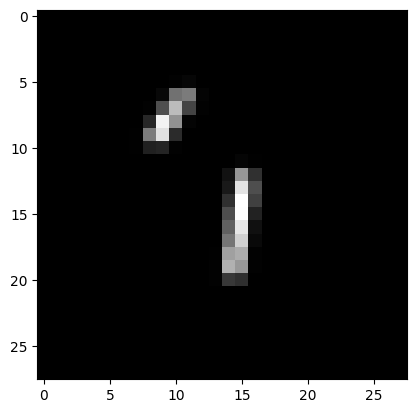

In [ ]:
plot_image = F.to_pil_image(processed_image)
plt.imshow(plot_image, cmap='gray')

¡Se ve bien! Pasémoslo a nuestro modelo.

### 4b.4 Hacer predicciones

Bien, ¡ahora estamos listos para predecir! Nuestro modelo sigue esperando un lote de imágenes. Si [squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.htmlhttps://pytorch.org/docs/stable/generated/torch.squeeze.html) elimina dimensiones de 1, [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.htmlhttps://pytorch.org/docs/stable/generated/torch.unsqueeze.html) añade una dimensión de 1 en el índice que especifiquemos. La primera dimensión suele ser la dimensión del lote, por lo que podemos decir `.unsqueeze(0)`.

In [ ]:
batched_image = processed_image.unsqueeze(0)
batched_image.shape

torch.Size([1, 1, 28, 28])

A continuación, debemos asegurarnos de que el tensor de entrada está en el mismo `dispositivo` que el modelo.

In [ ]:
batched_image_gpu = batched_image.to(device)
batched_image_gpu.device

device(type='cuda', index=0)

Ahora estamos listos para pasarlo al modelo.

In [ ]:
output = model(batched_image_gpu)
output

W0501 00:15:47.262000 332 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


tensor([[-4.5479,  3.0743, -1.5347, -5.3671, -7.6566, -2.9609, -3.4663, -2.2378,
         -6.2555, -6.2517]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)

### 4b.4.1 Comprender la predicción

Las predicciones tienen el formato de una matriz de 10
 longitudes. Cuanto mayor sea el valor, más probable es que la imagen de entrada pertenezca a la clase correspondiente. Hagámoslo un poco más legible. Podemos empezar por encontrar qué elemento de la matriz representa la mayor probabilidad. Esto puede hacerse fácilmente con la biblioteca numpy y la función [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [ ]:
prediction = output.argmax(dim=1).item()
prediction

1

In [ ]:
alphabet = "0123456789"

Ahora podemos pasar nuestro índice de predicción para encontrar la letra correspondiente.

In [ ]:
alphabet[prediction]

'1'

#### Ejercicio: Póngalo todo junto

In [ ]:
def plot_probabilities(logits, alphabet="0123456789"):

    if isinstance(logits, torch.Tensor):
        logits = logits.squeeze().detach().cpu()

    probs = torch.nn.functional.softmax(logits, dim=0).numpy()

    df = pd.DataFrame({'Clase': list(alphabet), 'Probabilidad': probs})

    plt.figure(figsize=(10, 5))

    sns.barplot(data=df, x="Clase", y="Probabilidad", hue="Clase", palette="viridis", legend=False)

    max_idx = np.argmax(probs)
    plt.title(f"Distribución de probabilidad - Predicción: {alphabet[max_idx]}")
    plt.xlabel("Clases")
    plt.ylabel("Probabilidad")
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


Pongamos todo en una función para que podamos hacer predicciones sólo a partir del archivo de imagen. Impleméntalo en la función de abajo usando las funciones y pasos anteriores. Si necesitas ayuda, puedes revelar la solución haciendo clic en los tres puntos de abajo.

In [ ]:
def predict_letter(file_path):
    # Show image
    show_image(file_path)
    # Load and grayscale image
    image = tv_io.read_image(file_path, tv_io.ImageReadMode.GRAY)
    #image = 255 - image
    # Transform image
    image = preprocess_trans(image)
    # Batch image
    image = image.unsqueeze(0)
    # Send image to correct device
    image = image.to(device)
    # Make prediction
    output = model(image)

    plot_probabilities(output)

    # Find max index
    prediction = output.argmax(dim=1).item()
    # Convert prediction to letter
    predicted_letter = alphabet[prediction]
    # Return prediction
    return predicted_letter

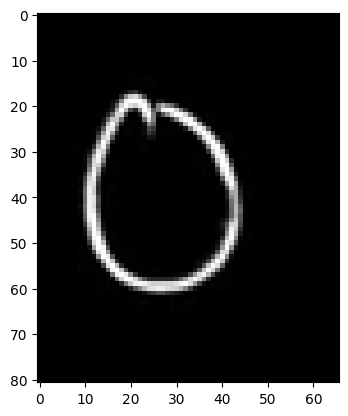

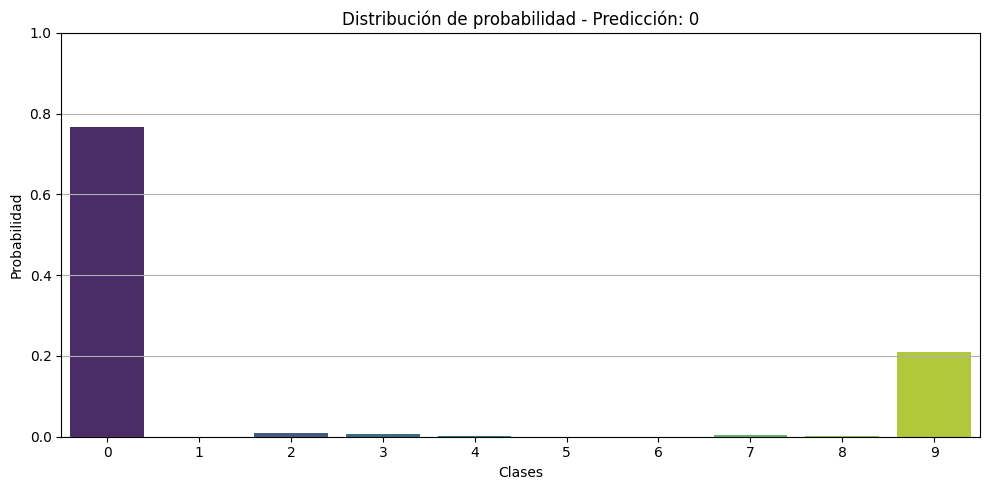

'0'

In [ ]:
predict_letter('/content/test/number/0.png')


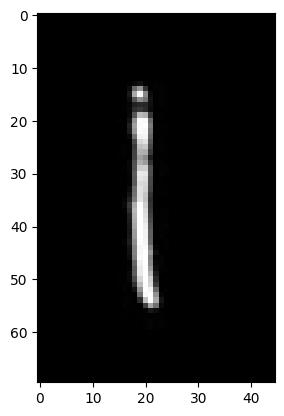

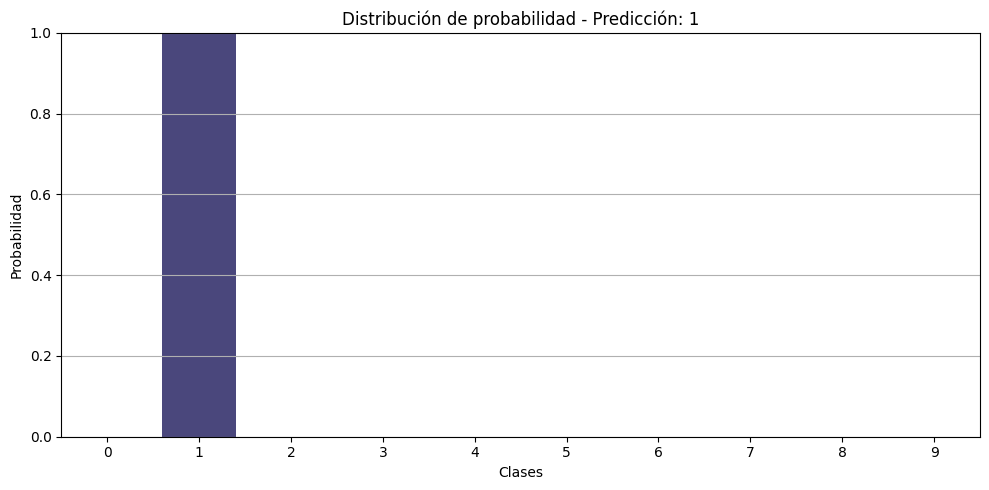

'1'

In [ ]:
predict_letter('/content/test/number/1.png')

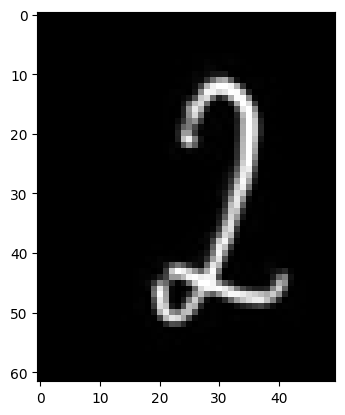

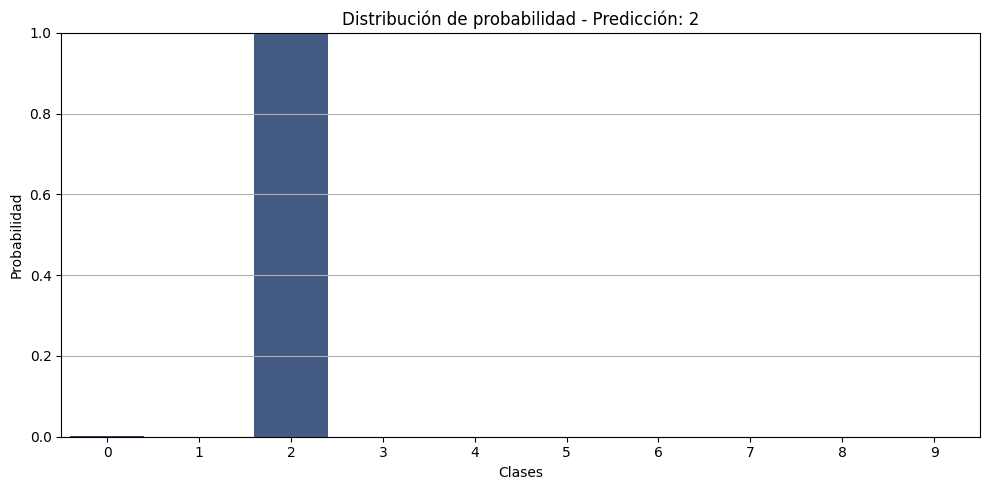

'2'

In [ ]:
predict_letter('/content/test/number/2.png')

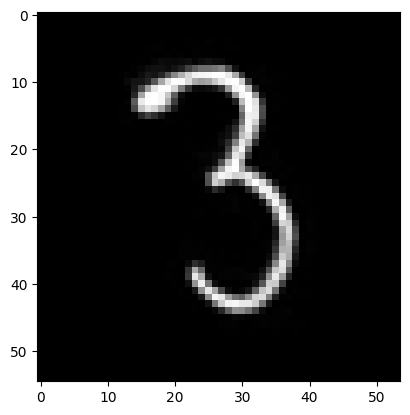

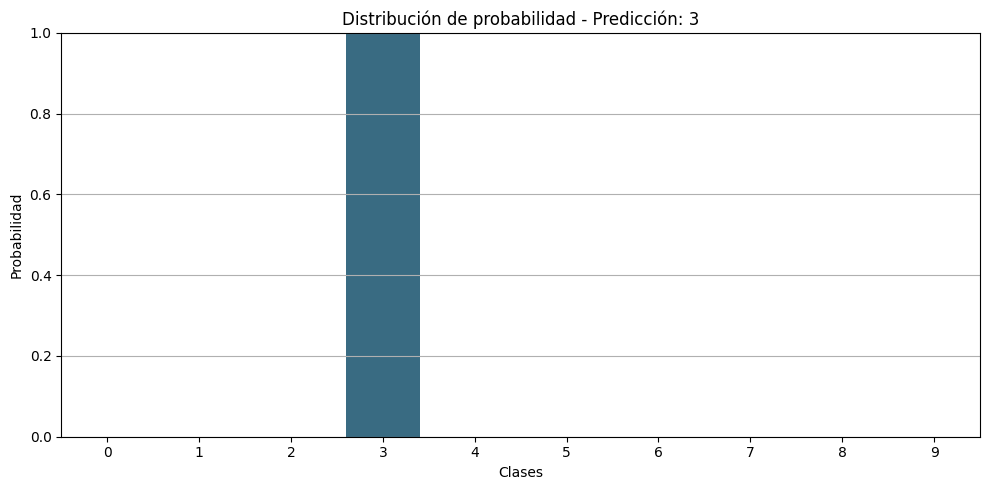

'3'

In [ ]:
predict_letter('/content/test/number/3.png')

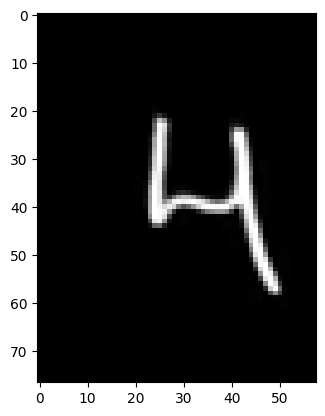

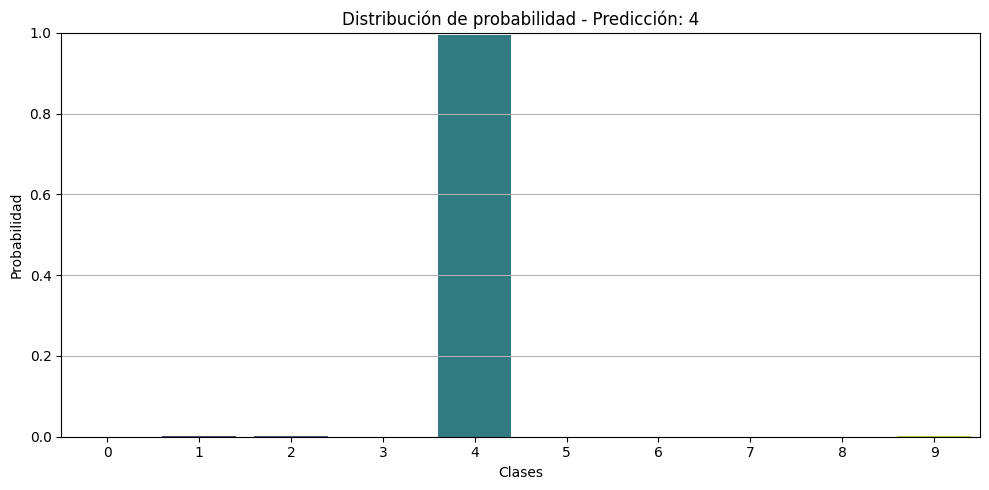

'4'

In [ ]:
predict_letter('/content/test/number/4.png')

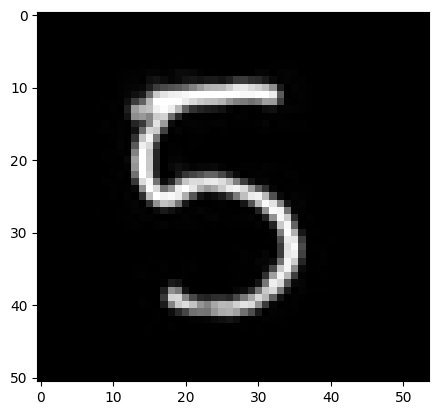

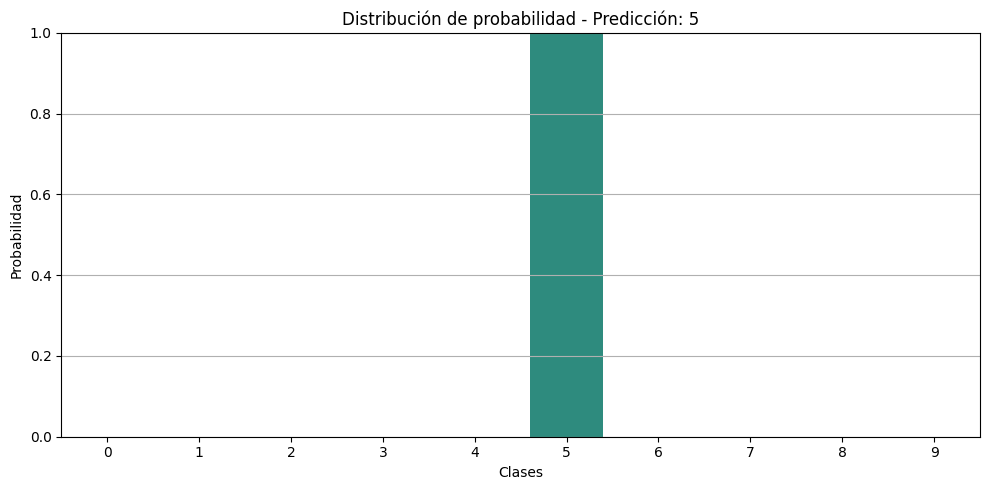

'5'

In [ ]:
predict_letter('/content/test/number/5.png')

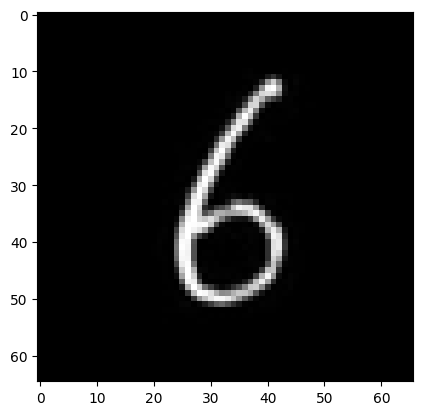

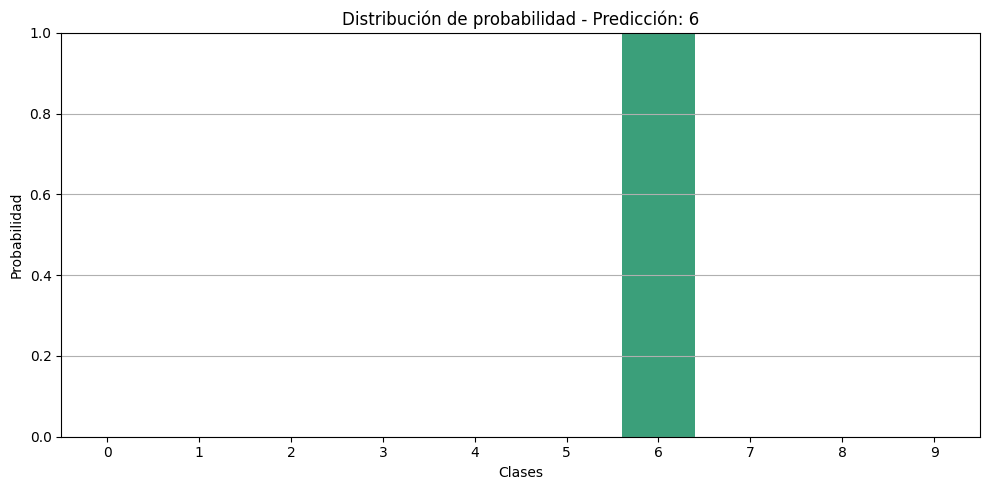

'6'

In [ ]:
predict_letter('/content/test/number/6.png')

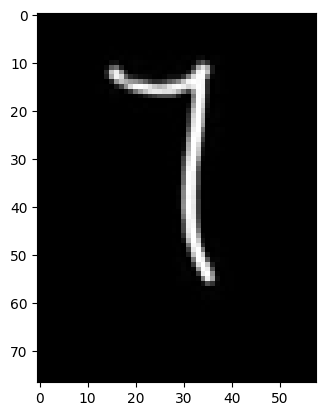

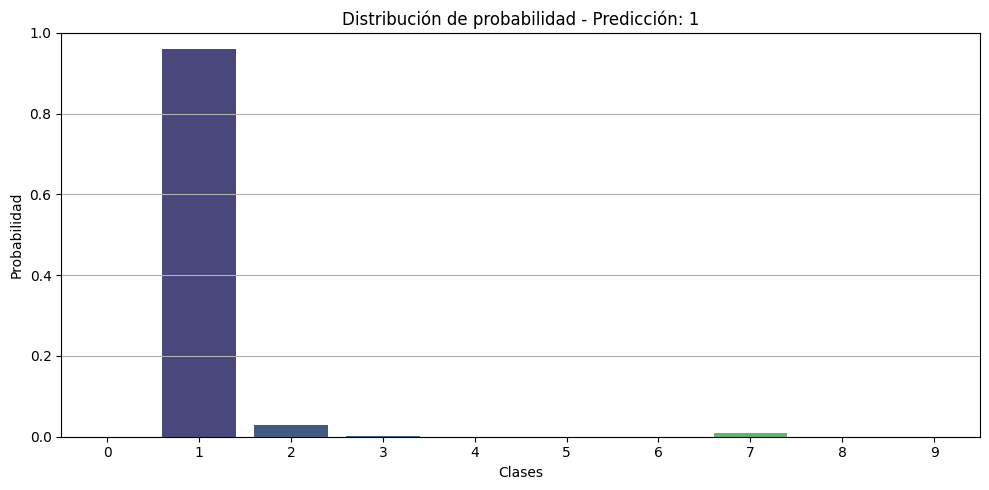

'1'

In [ ]:
predict_letter('/content/test/number/7.png')

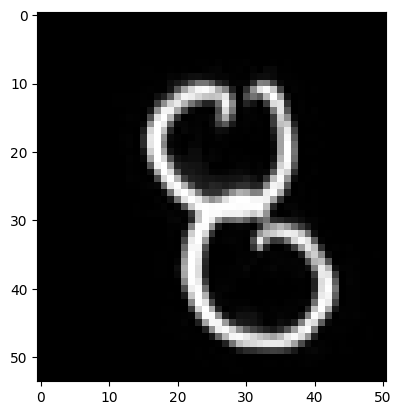

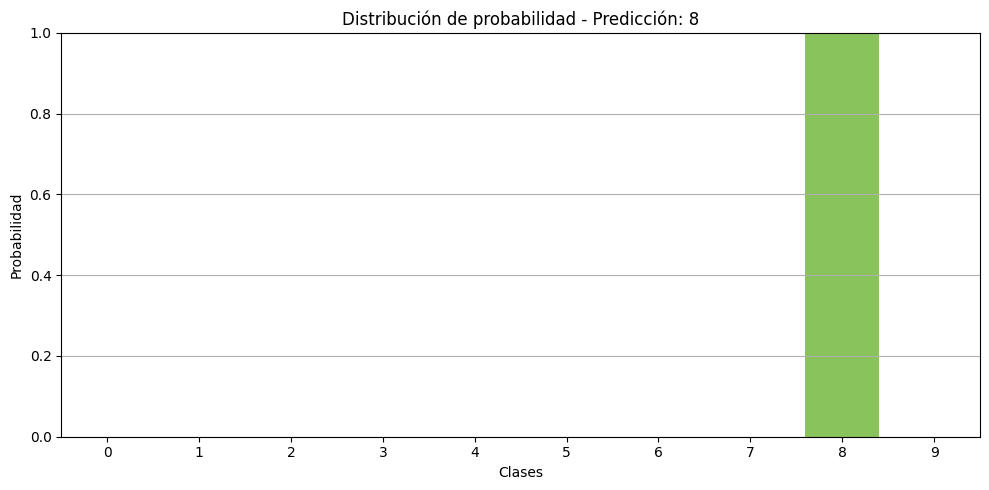

'8'

In [ ]:
predict_letter('/content/test/number/8.png')

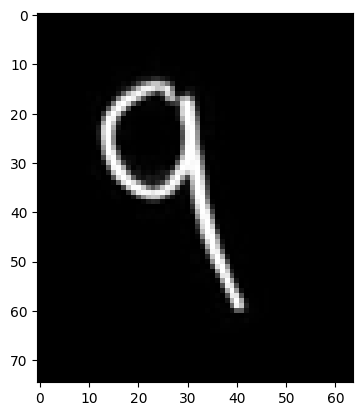

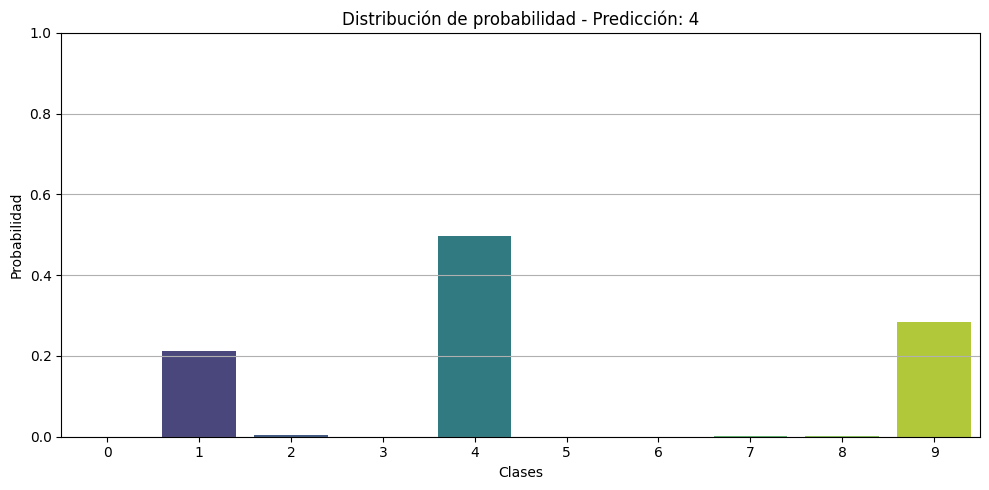

'4'

In [ ]:
predict_letter('/content/test/number/9.png')

#Conclusión números normales
Como se observa en los numeros "normales" tuvo una acertividad de 8 de 10, donde se equivoco tanto en el 7 como en el 9 , y parece ser que es devido a que el 7 que escribí no tiene rayita en medio y el 9 al ser muy redondo y dejando un espacio pequeño lo interpreto como 4 como probabilidad máxima, sin embargo el valor 9 tenia un 30% de probabilidades en su distribución de probabilidad

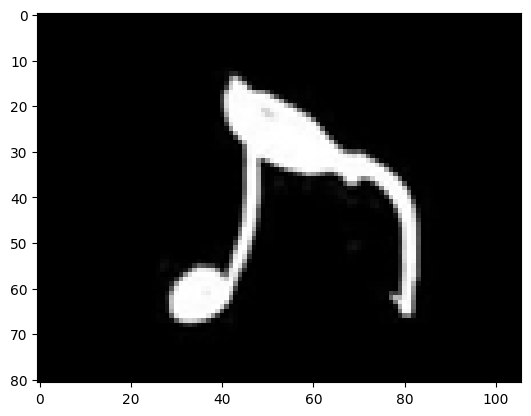

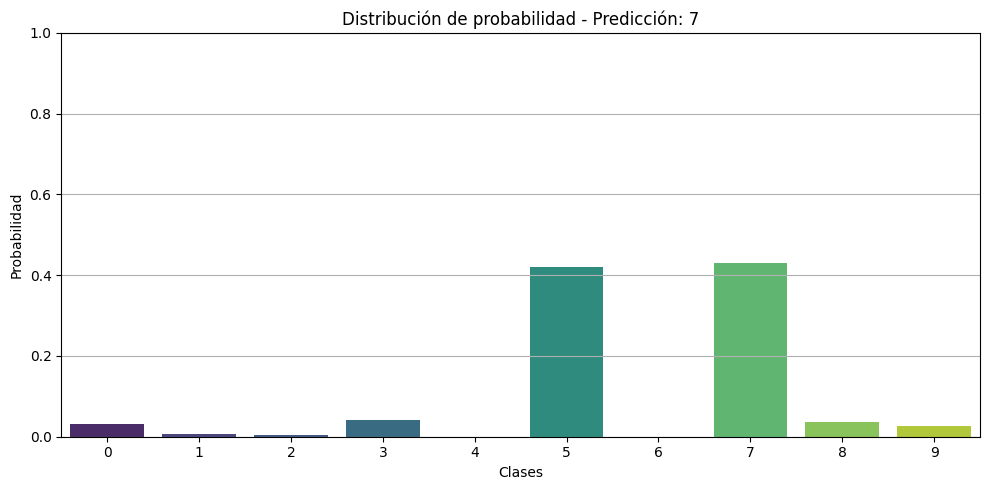

'7'

In [ ]:
predict_letter('/content/test/symbol/symbol1.png')

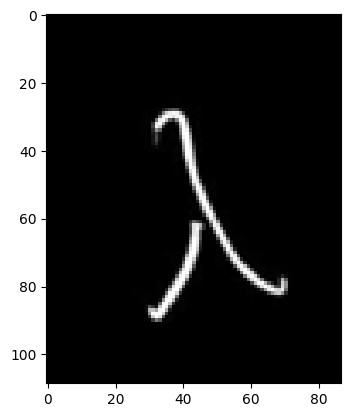

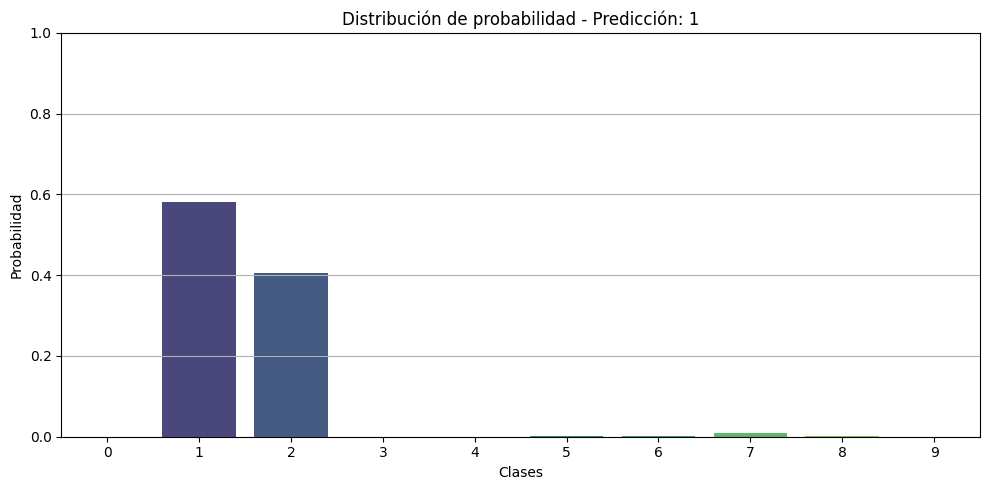

'1'

In [ ]:
predict_letter('/content/test/symbol/symbol2.png')

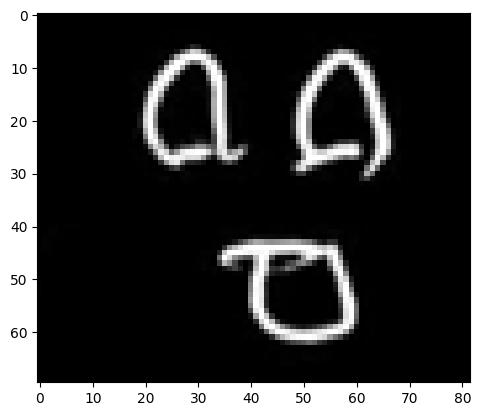

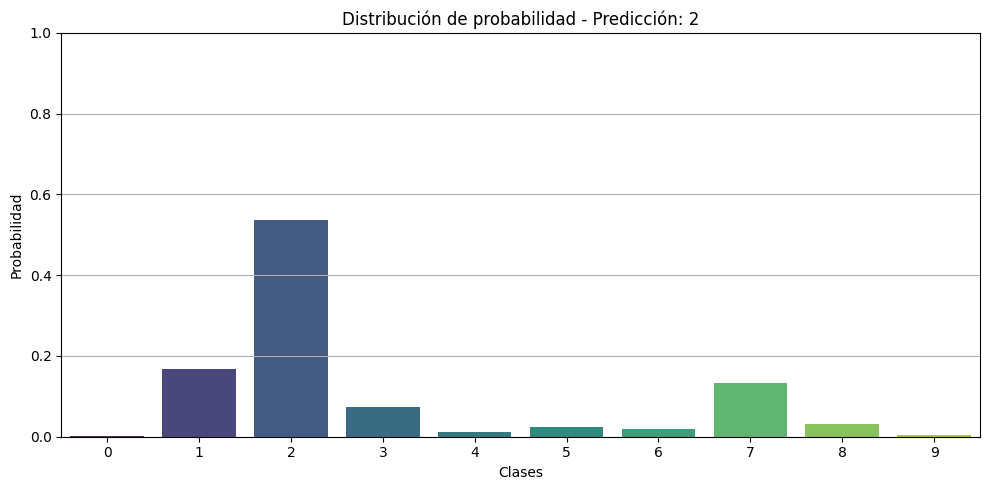

'2'

In [ ]:
predict_letter('/content/test/symbol/symbol3.png')

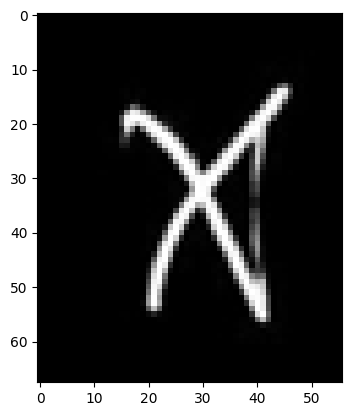

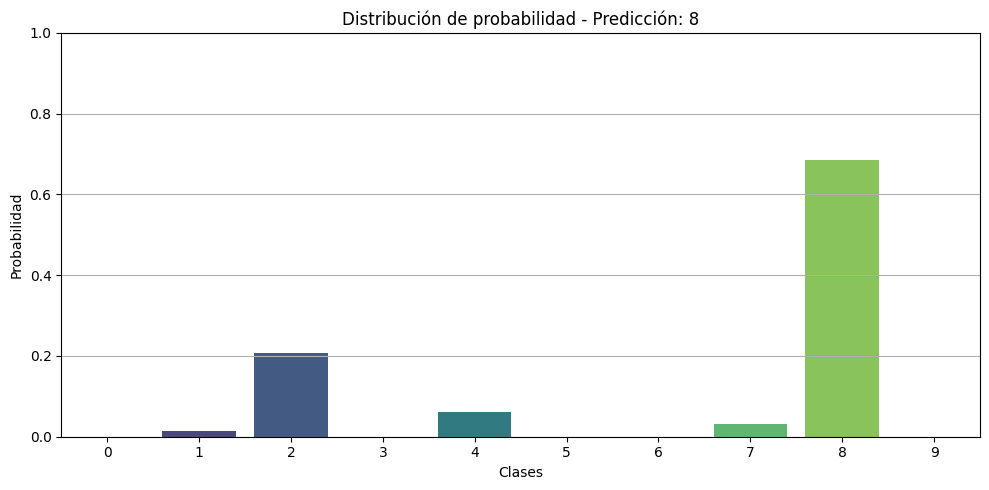

'8'

In [ ]:
predict_letter('/content/test/symbol/symbol4.png')

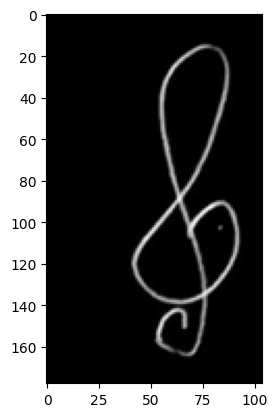

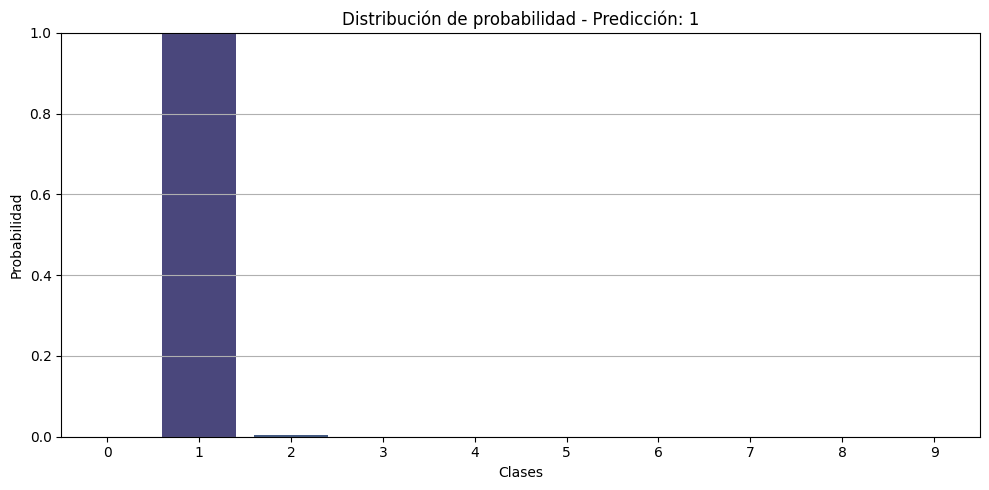

'1'

In [ ]:
predict_letter('/content/test/symbol/symbol5.png')

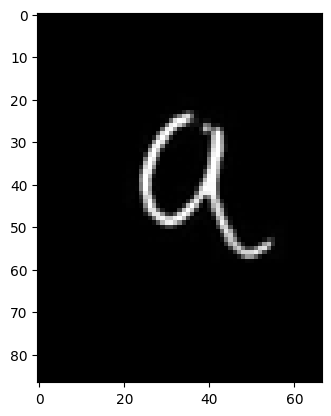

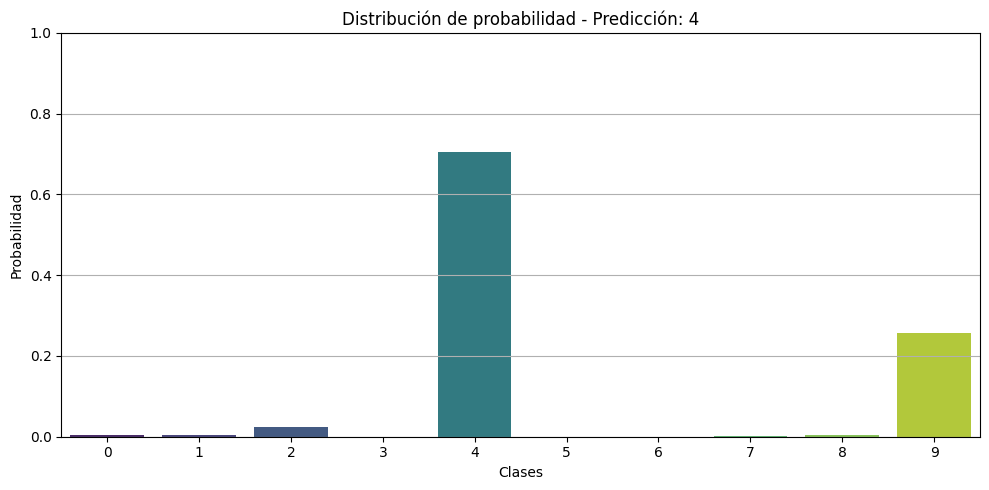

'4'

In [ ]:
predict_letter('/content/test/symbol/symbol6.png')

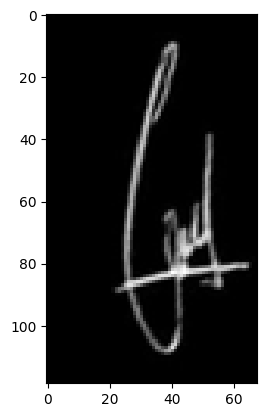

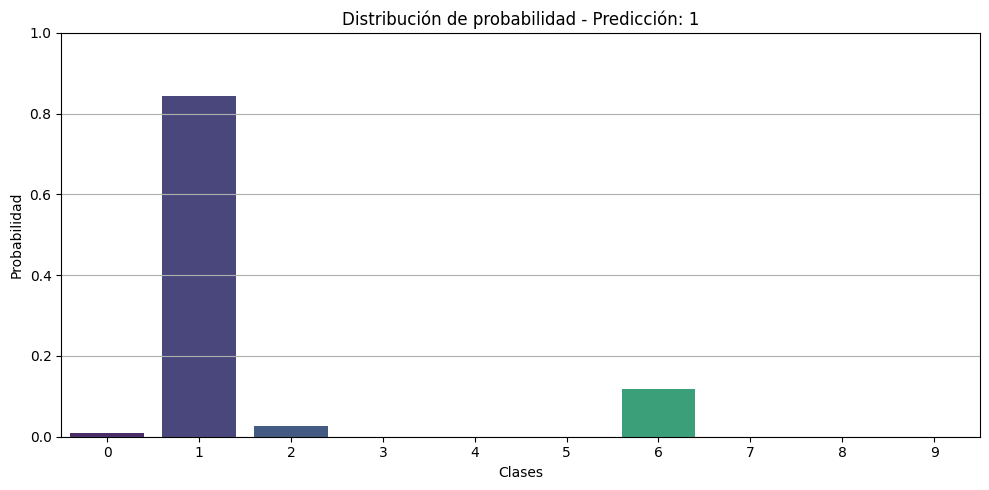

'1'

In [ ]:
predict_letter('/content/test/symbol/symbol7.png')

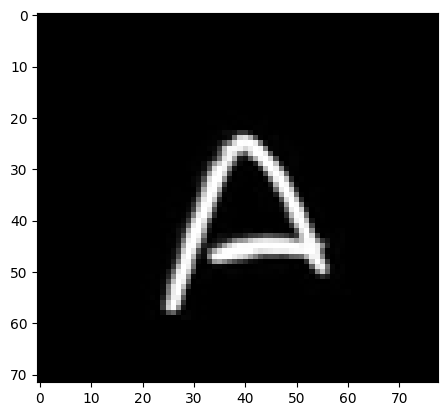

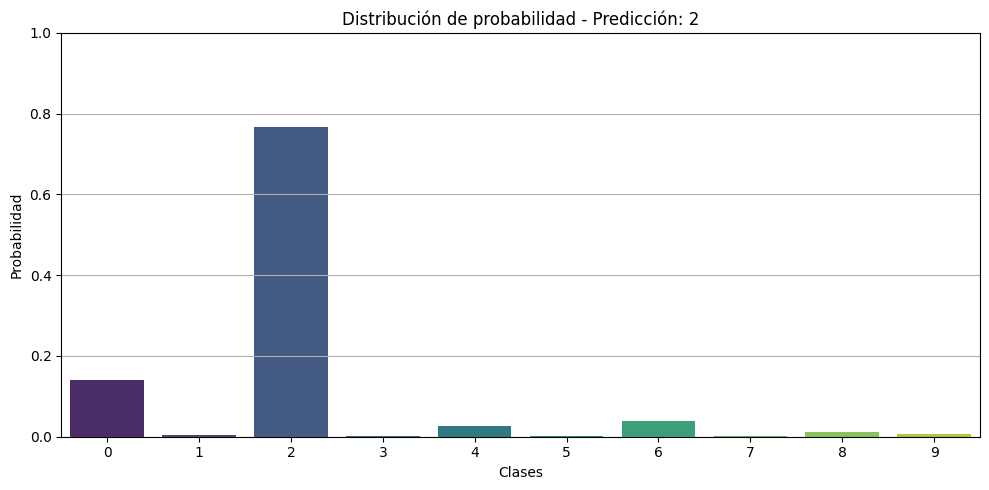

'2'

In [ ]:
predict_letter('/content/test/symbol/symbol8.png')

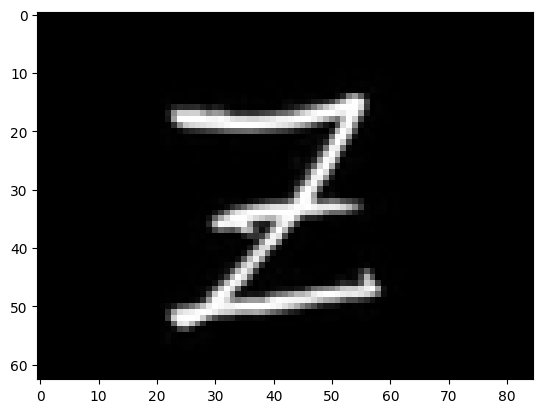

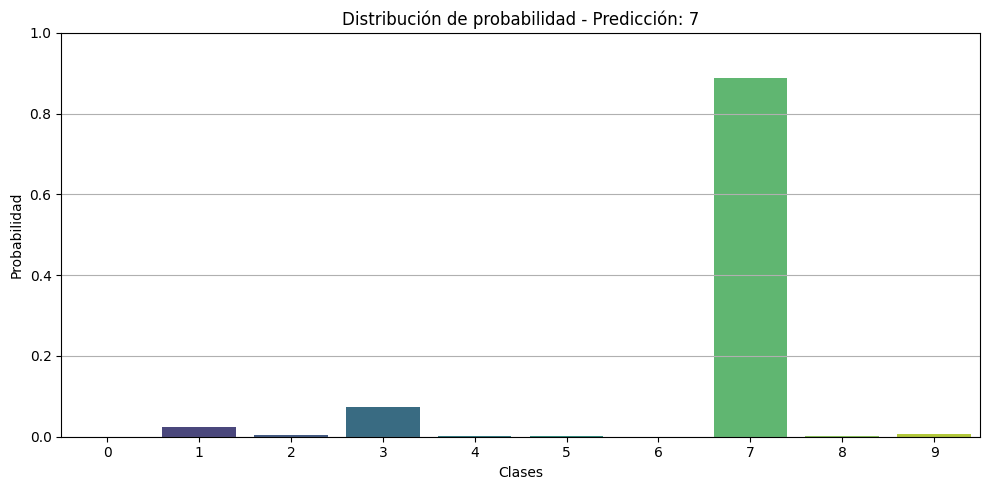

'7'

In [ ]:
predict_letter('/content/test/symbol/symbol9.png')

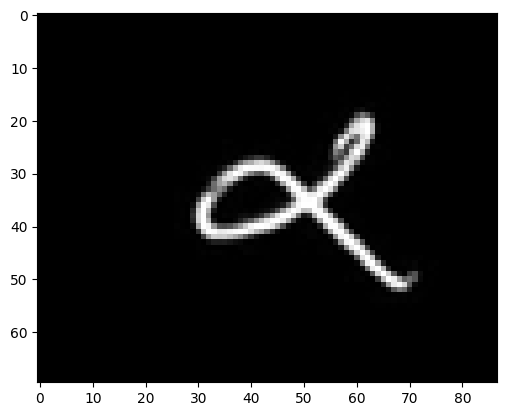

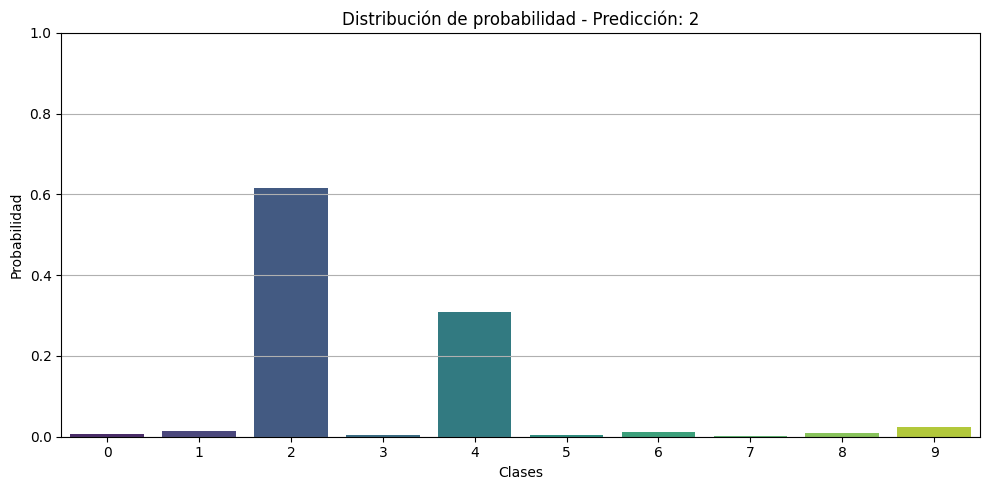

'2'

In [ ]:
predict_letter('/content/test/symbol/symbol10.png')

#Conclusión de symbolos
Con respecto a los simbolos, por obvias razones el modelo no predeciria una clasificación que no tiene integrado, sin embargo el modelo para ser que se baso en caracteristicas bastante complejas, no aptas para el ojo humano para predecir, un claro ejemplo es la clave sol "𝄞" que a simple vista uno diria que el número mas cercano a parecerse es el 8 sin embargo el modelo predijo que es el 1, lo cual esta bastante alejado de la forma de la clave sol

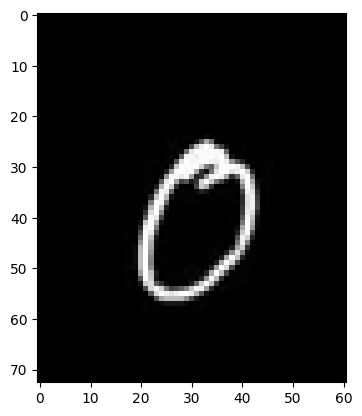

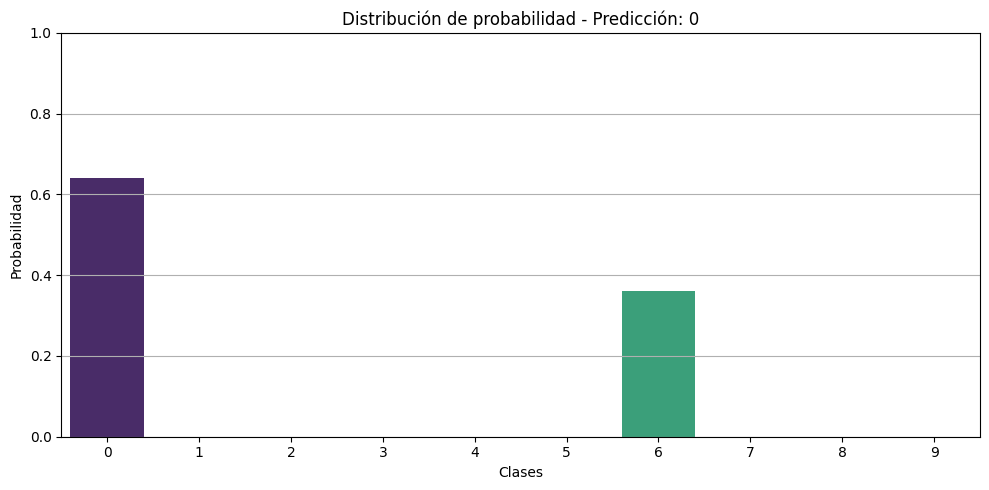

'0'

In [ ]:
predict_letter('/content/test/rotation/0.png')

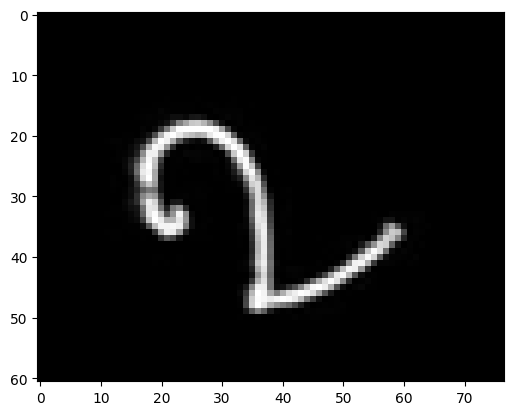

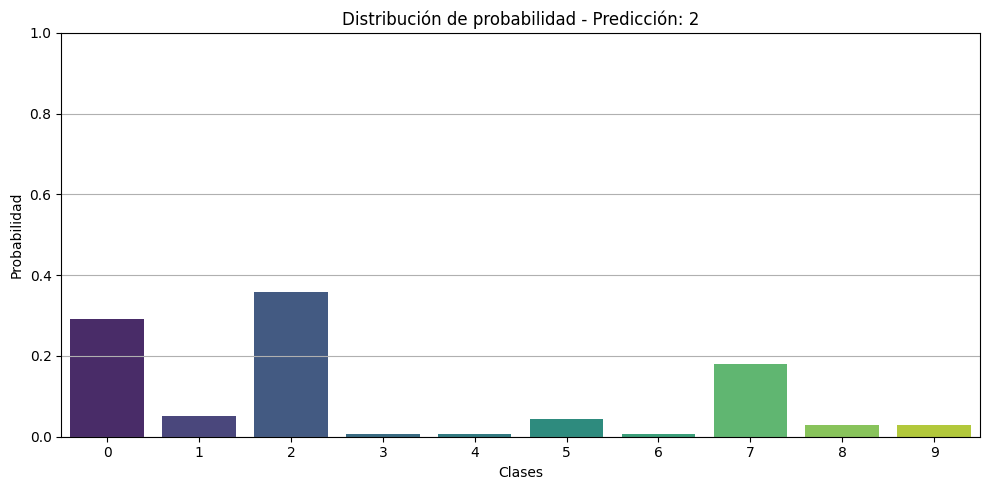

'2'

In [ ]:
predict_letter('/content/test/rotation/2.png')

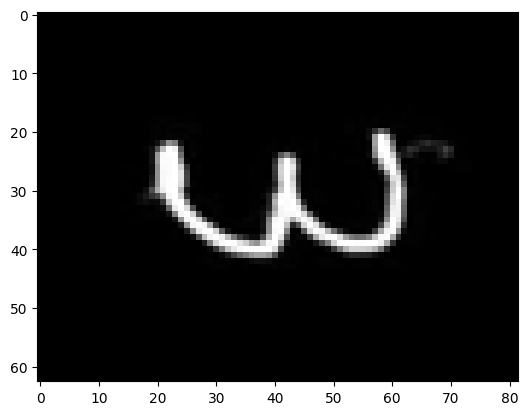

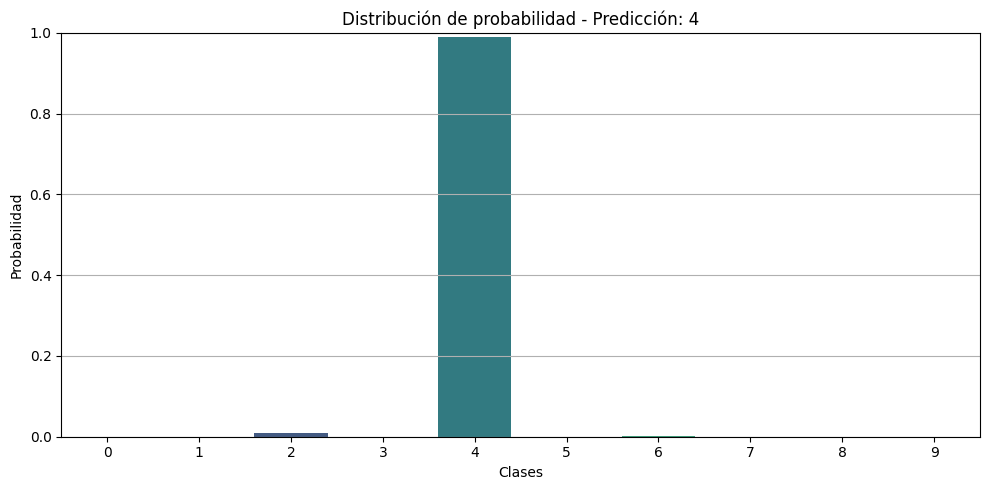

'4'

In [ ]:
predict_letter('/content/test/rotation/3.png')

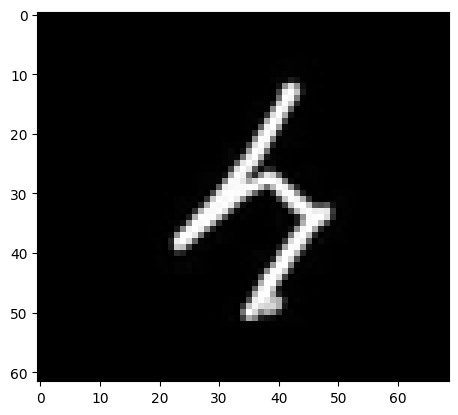

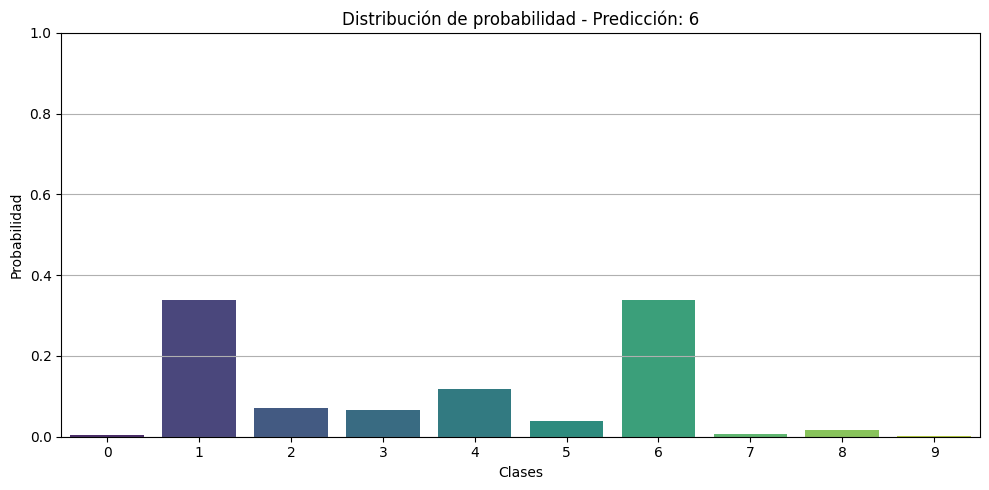

'6'

In [ ]:
predict_letter('/content/test/rotation/4.png')

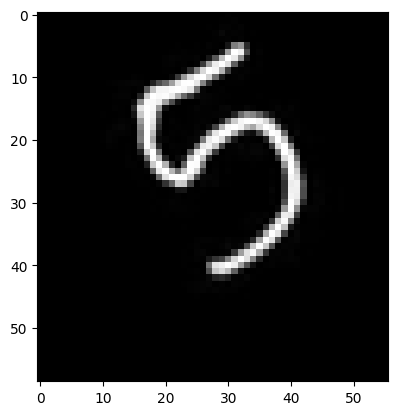

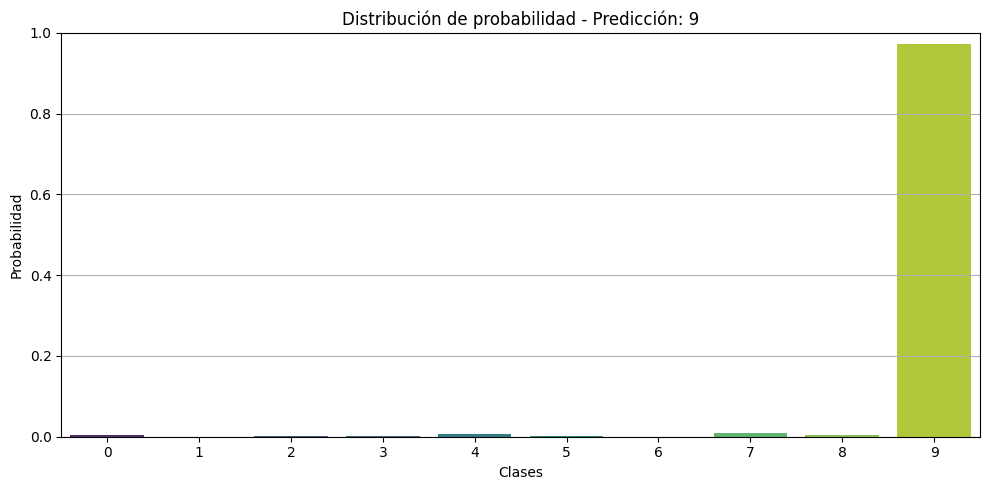

'9'

In [ ]:
predict_letter('/content/test/rotation/5.png')

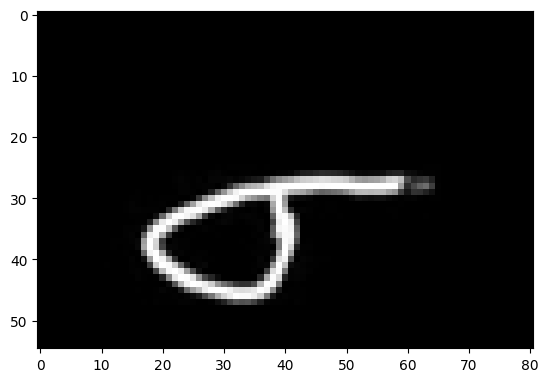

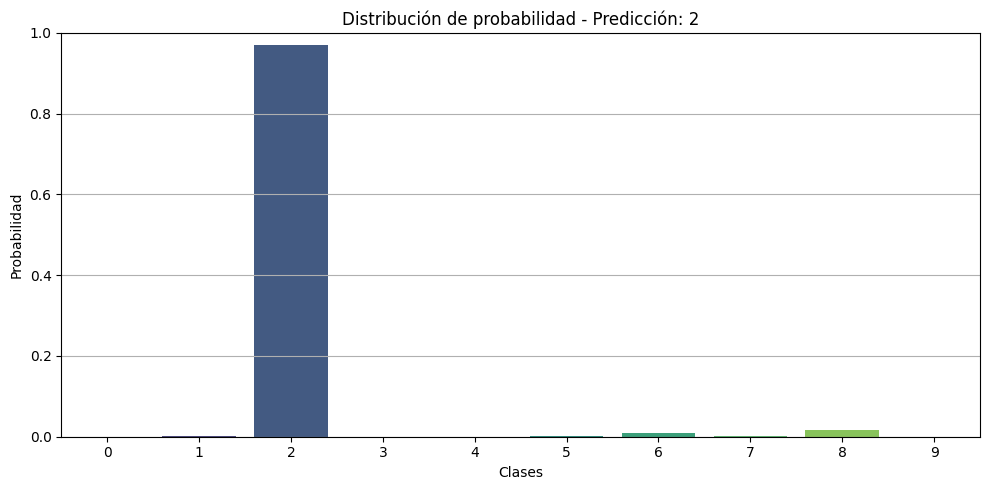

'2'

In [ ]:
predict_letter('/content/test/rotation/6.png')

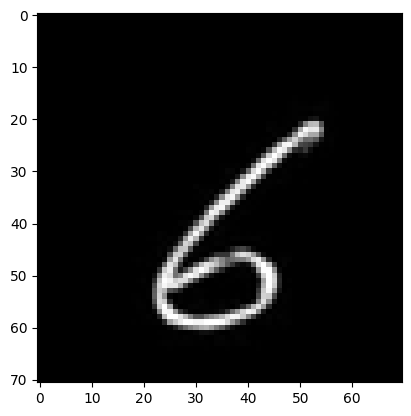

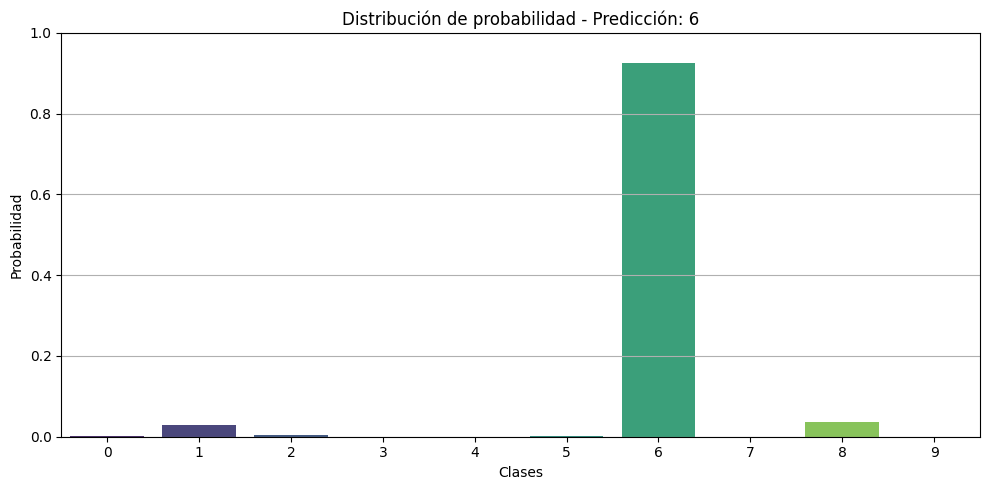

'6'

In [ ]:
predict_letter('/content/test/rotation/6 (2).png')

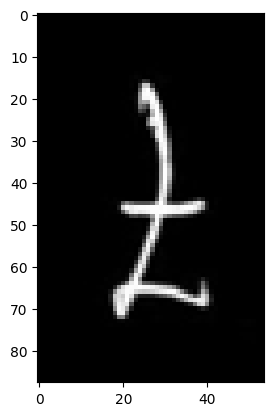

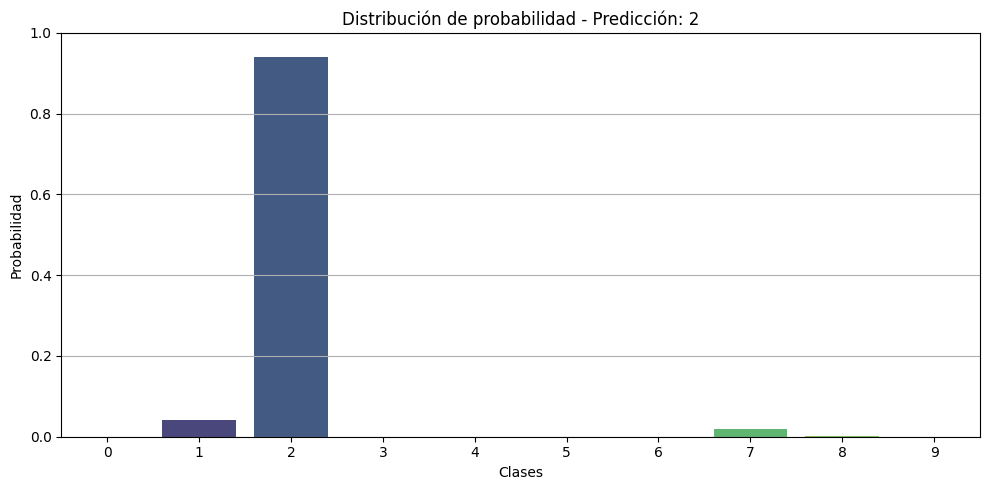

'2'

In [ ]:
predict_letter('/content/test/rotation/7.png')

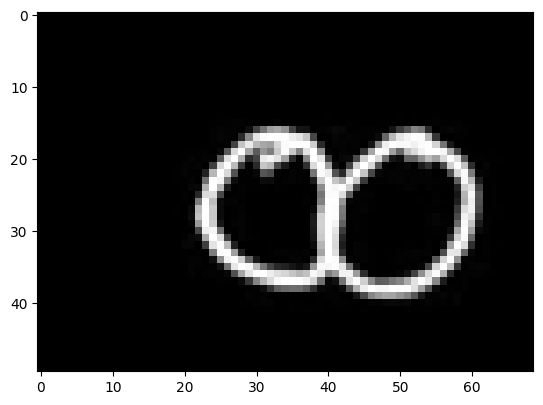

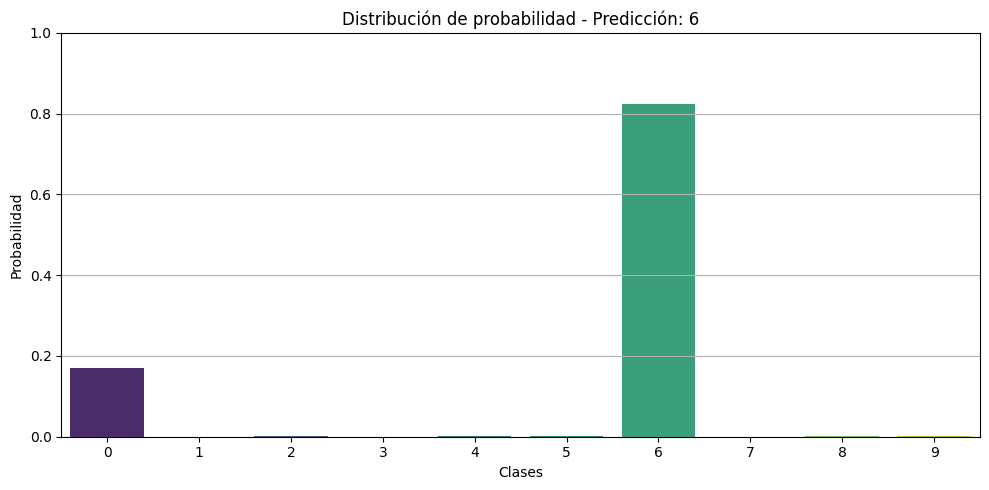

'6'

In [ ]:
predict_letter('/content/test/rotation/8.png')

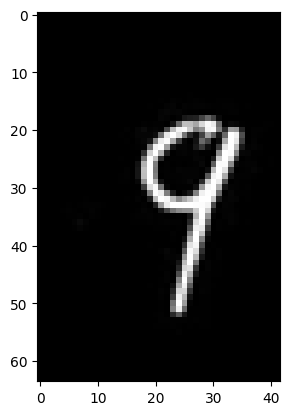

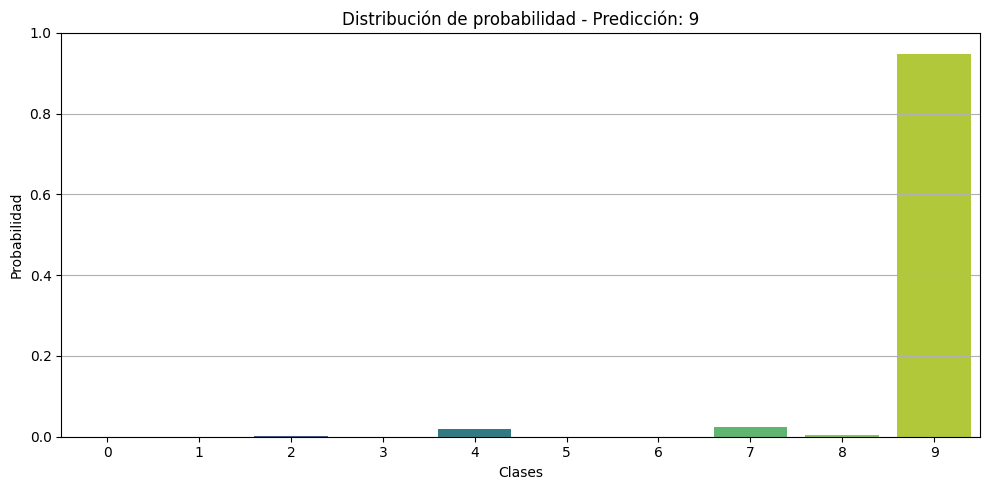

'9'

In [ ]:
predict_letter('/content/test/rotation/9.png')

#Conclusión número con rotación
Las rotaciones representan un desafío considerable para el modelo de reconocimiento de dígitos basado en MNIST. La precisión obtenida fue de apenas 4 aciertos sobre 10, lo que evidencia que el modelo no generaliza bien ante variaciones angulares en las imágenes. En varios casos, la clase correcta no solo dejó de ser la opción más probable, sino que fue desplazada por otras con baja diferencia de probabilidad, indicando una alta incertidumbre en la predicción.

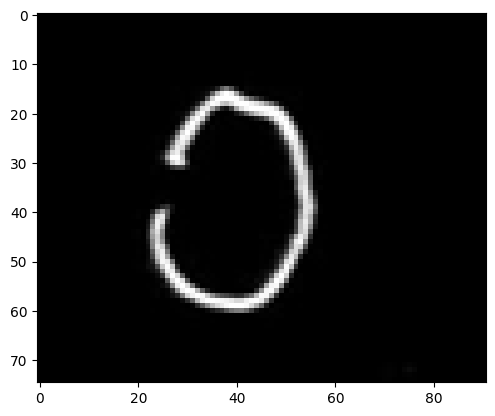

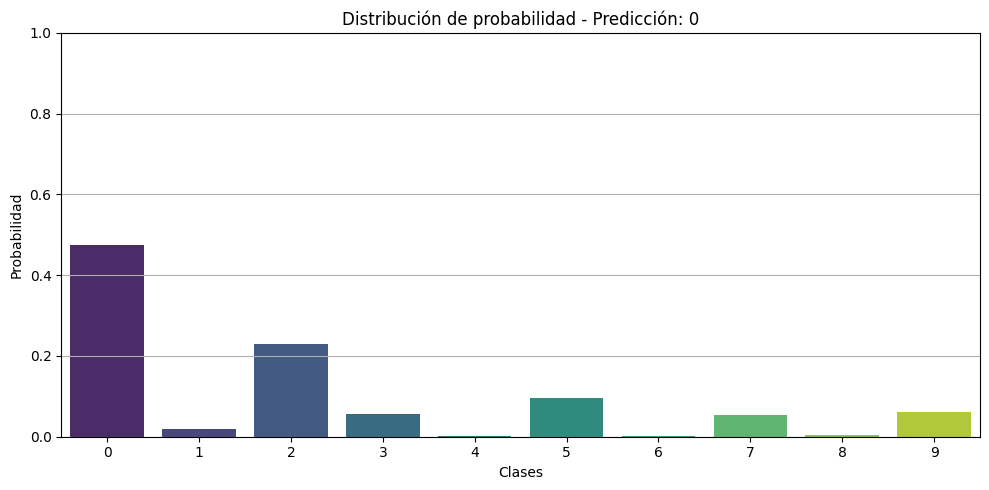

'0'

In [ ]:
predict_letter('/content/test/blot/0.png')

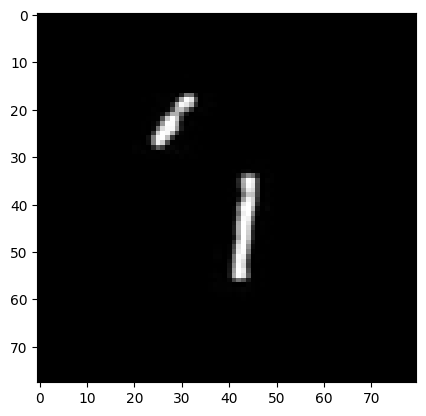

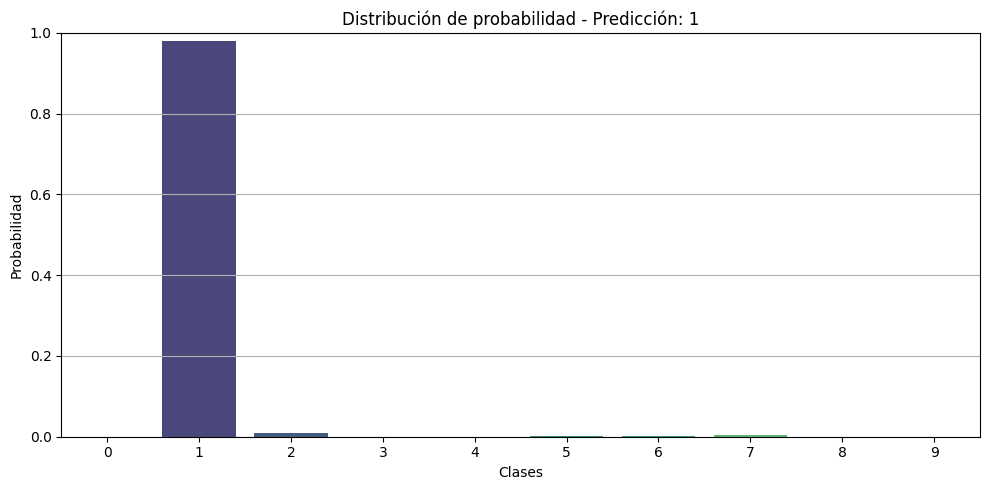

'1'

In [ ]:
predict_letter('/content/test/blot/1.png')

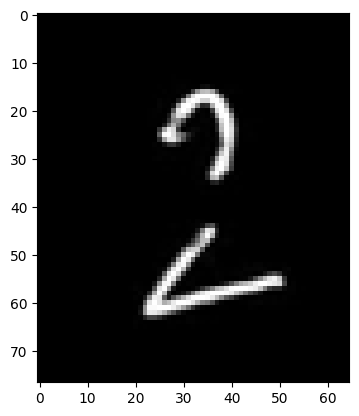

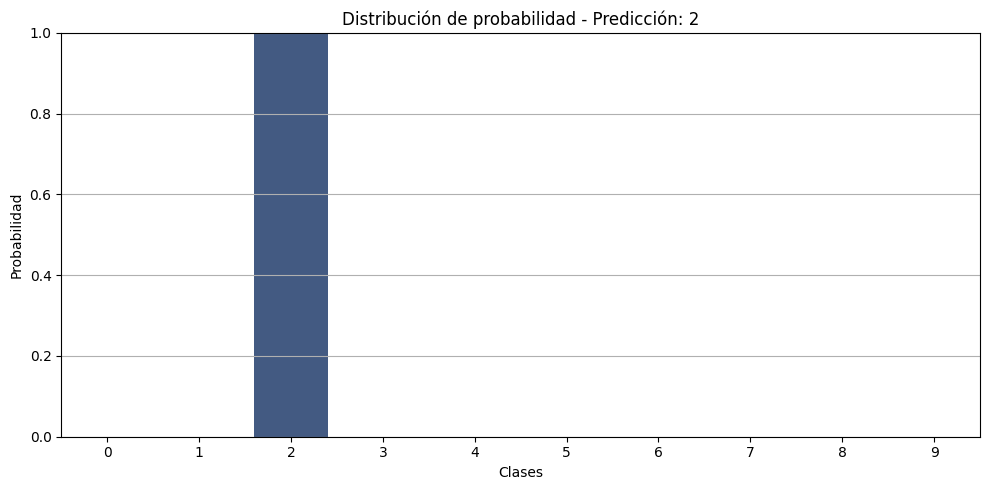

'2'

In [ ]:
predict_letter('/content/test/blot/2.png')

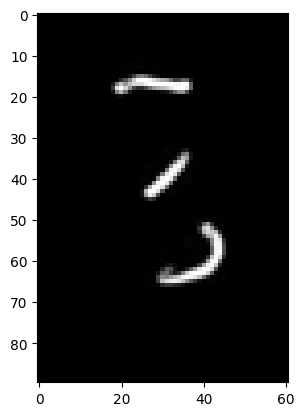

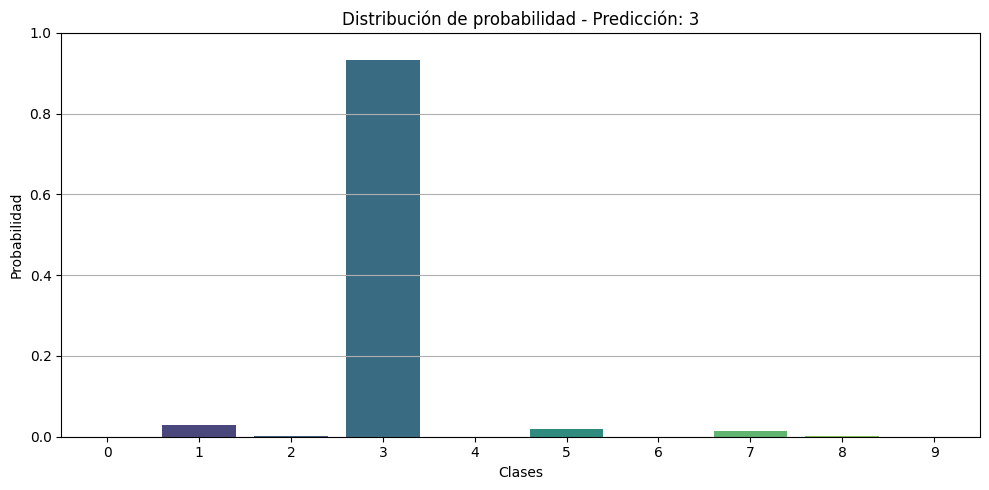

'3'

In [ ]:
predict_letter('/content/test/blot/3.png')

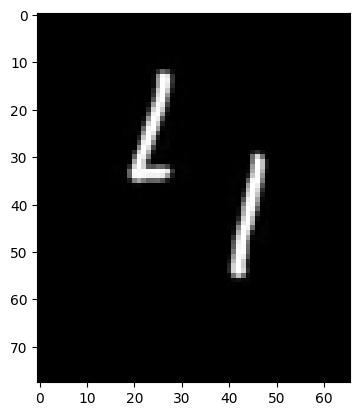

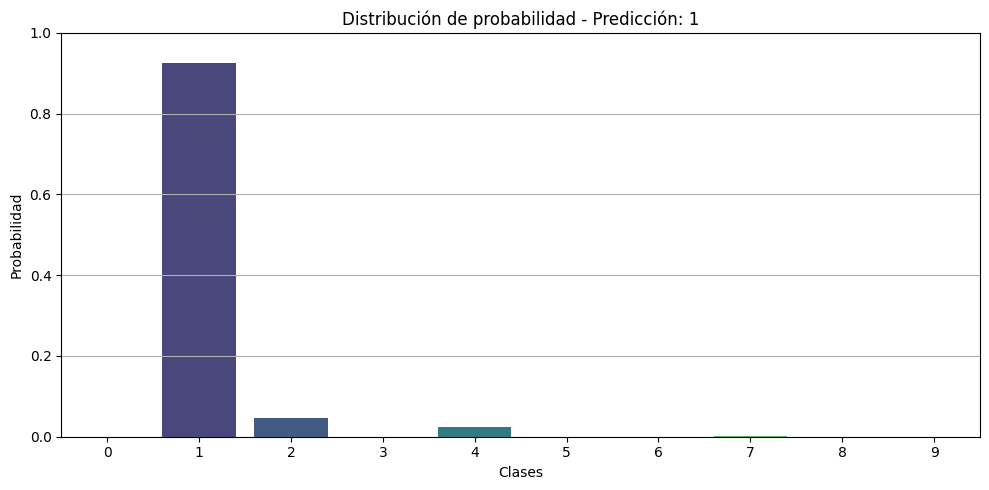

'1'

In [ ]:
predict_letter('/content/test/blot/4.png')

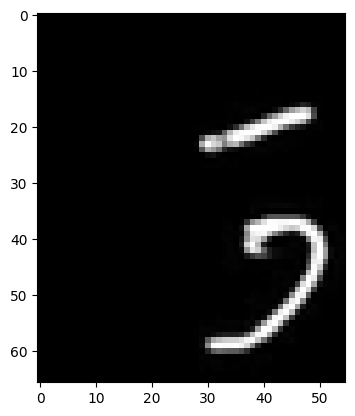

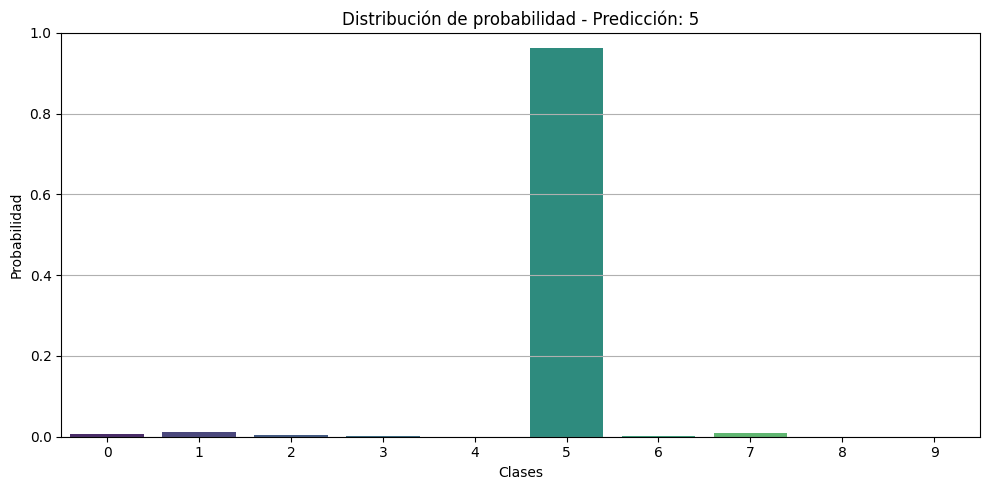

'5'

In [ ]:
predict_letter('/content/test/blot/5.png')

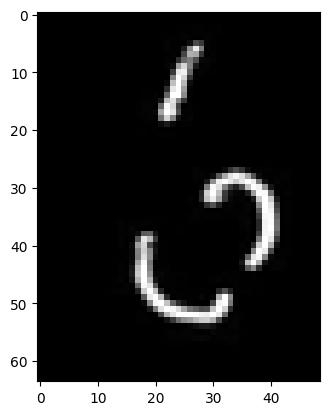

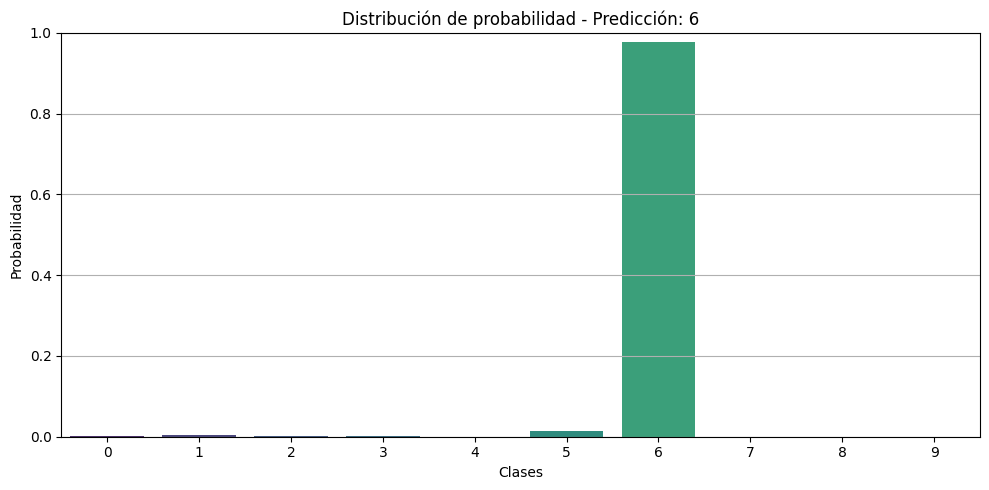

'6'

In [ ]:
predict_letter('/content/test/blot/6.png')

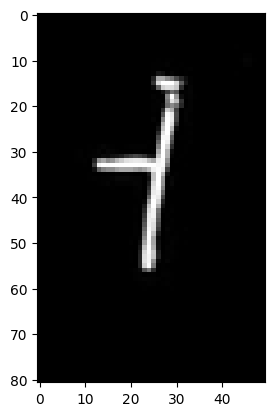

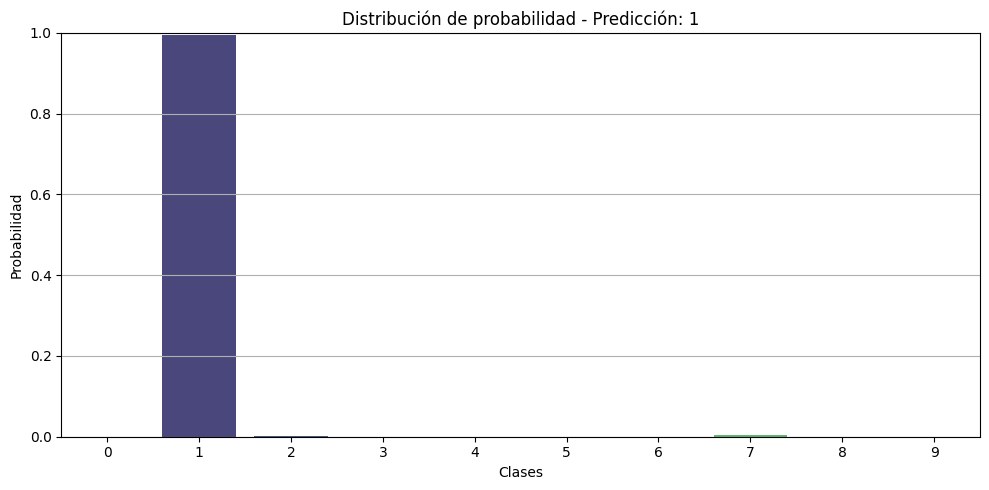

'1'

In [ ]:
predict_letter('/content/test/blot/7.png')

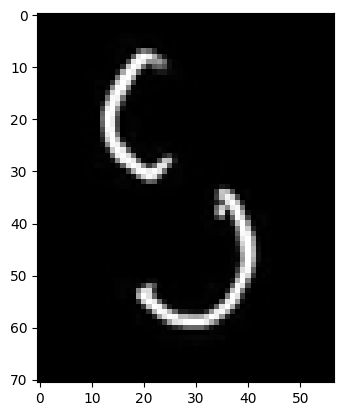

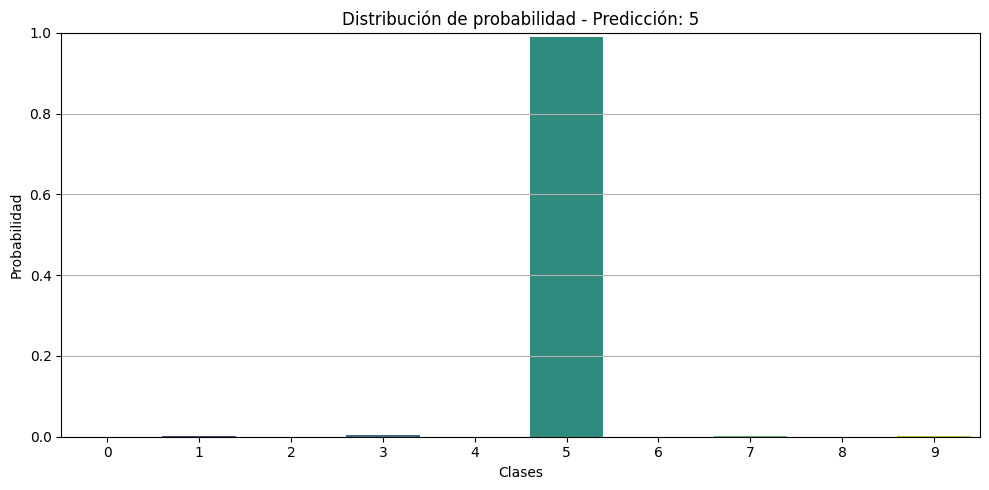

'5'

In [ ]:
predict_letter('/content/test/blot/8.png')

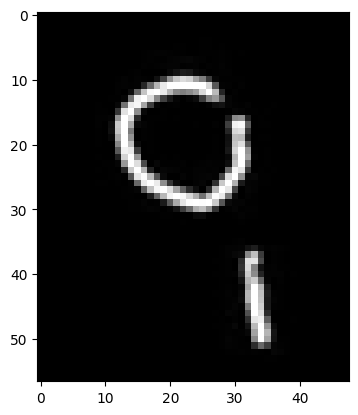

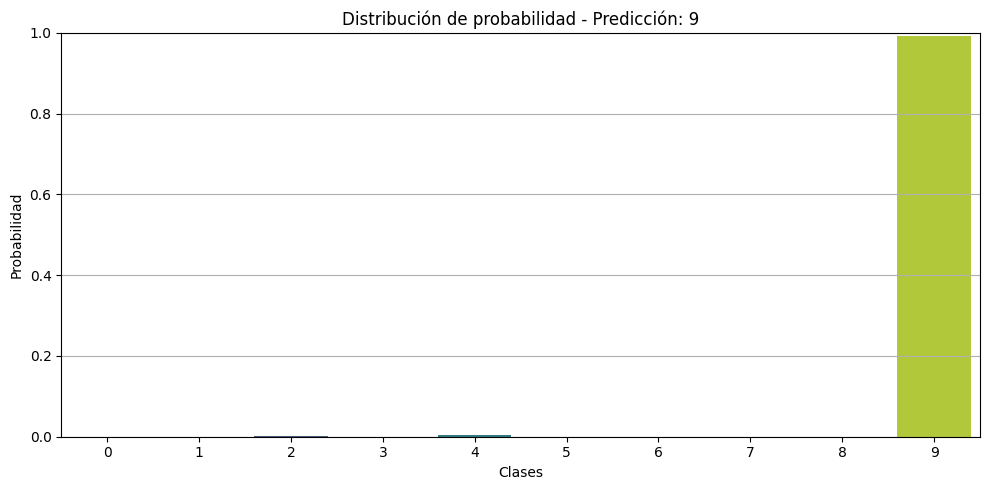

'9'

In [ ]:
predict_letter('/content/test/blot/9.png')

#Conclusión números con borrones
En el caso de los números con borrones, el modelo logró una precisión de aproximadamente 6 de 10, lo cual indica una capacidad moderada de generalización ante imágenes deterioradas. Este rendimiento puede atribuirse en parte al uso de técnicas como dropout durante el entrenamiento, que ayudan al modelo a volverse más robusto al obligarlo a aprender patrones relevantes incluso cuando partes de la información visual están ausentes.

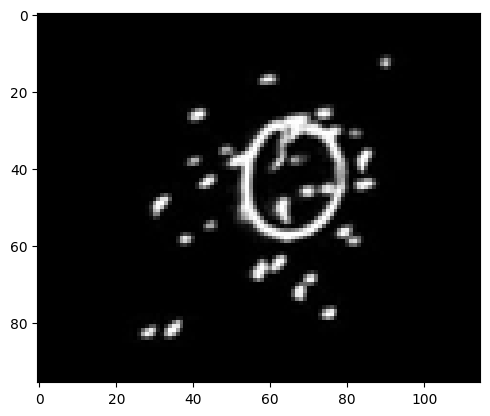

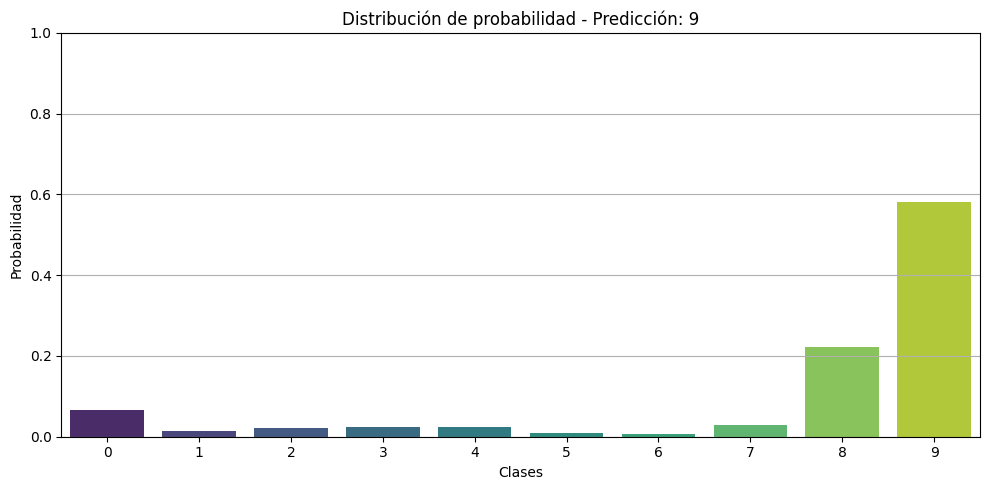

'9'

In [ ]:
predict_letter('/content/test/noise/0.png')

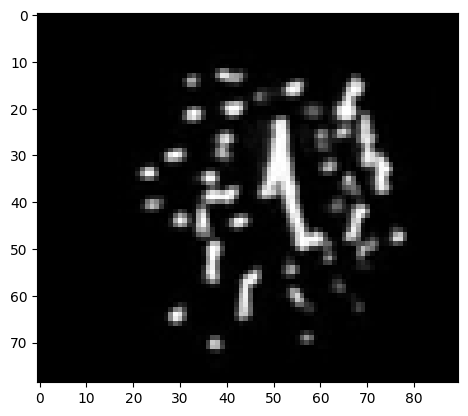

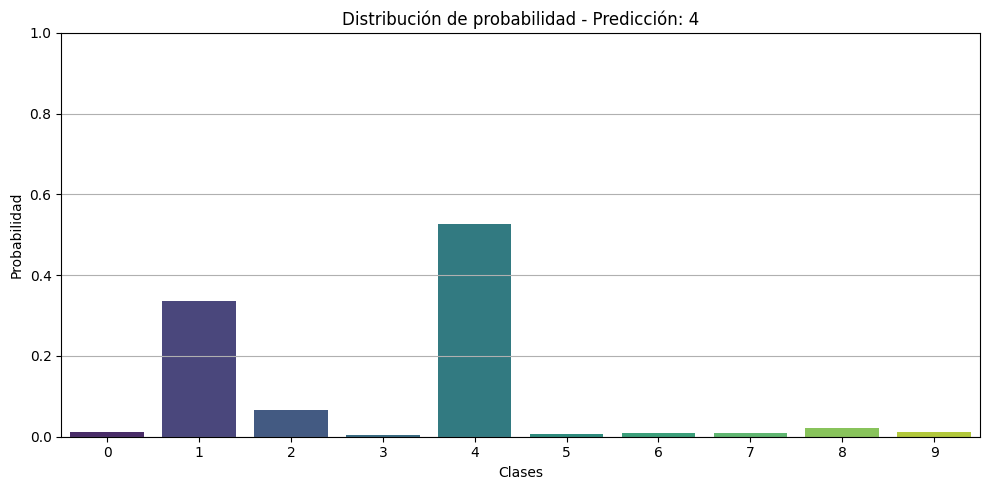

'4'

In [ ]:
predict_letter('/content/test/noise/1.png')

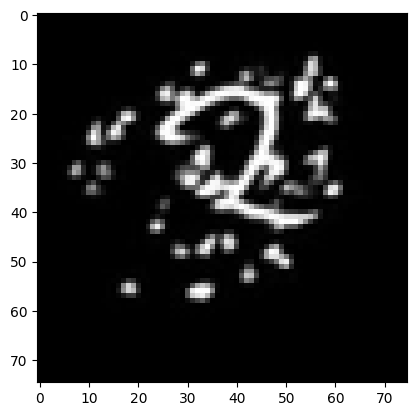

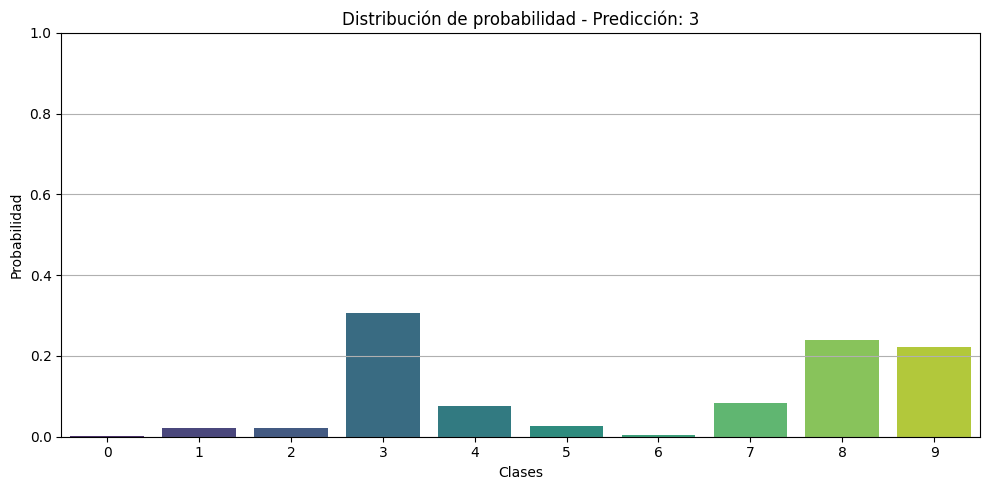

'3'

In [ ]:
predict_letter('/content/test/noise/2.png')

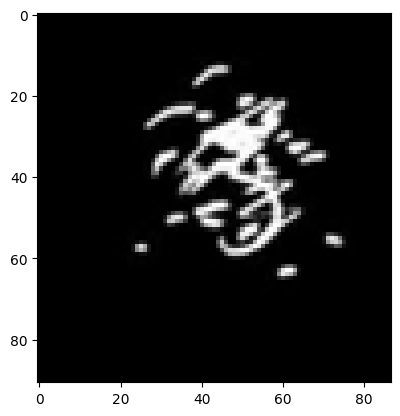

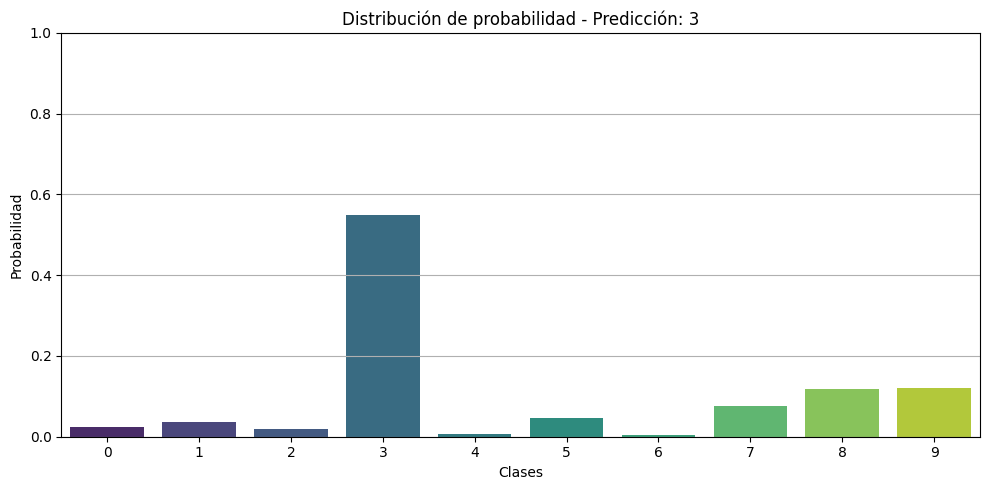

'3'

In [ ]:
predict_letter('/content/test/noise/3.png')

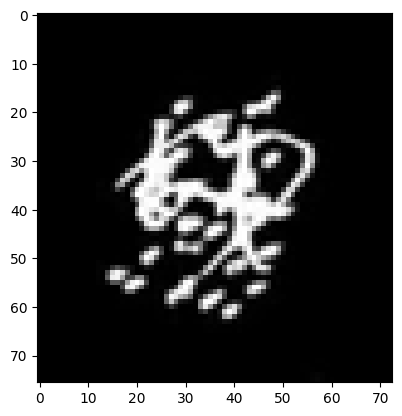

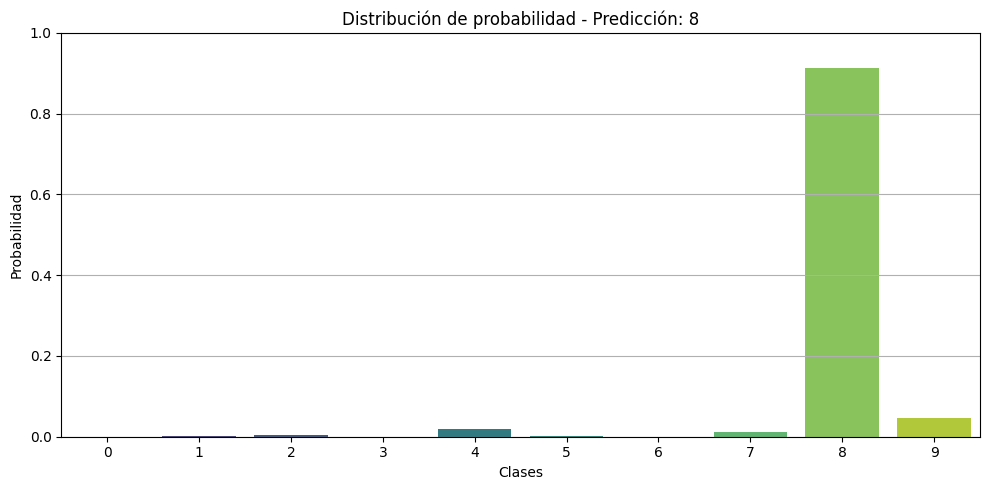

'8'

In [ ]:
predict_letter('/content/test/noise/4.png')

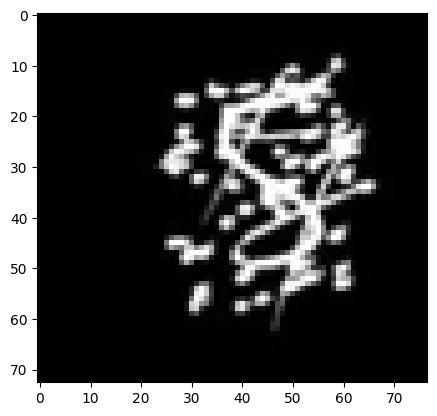

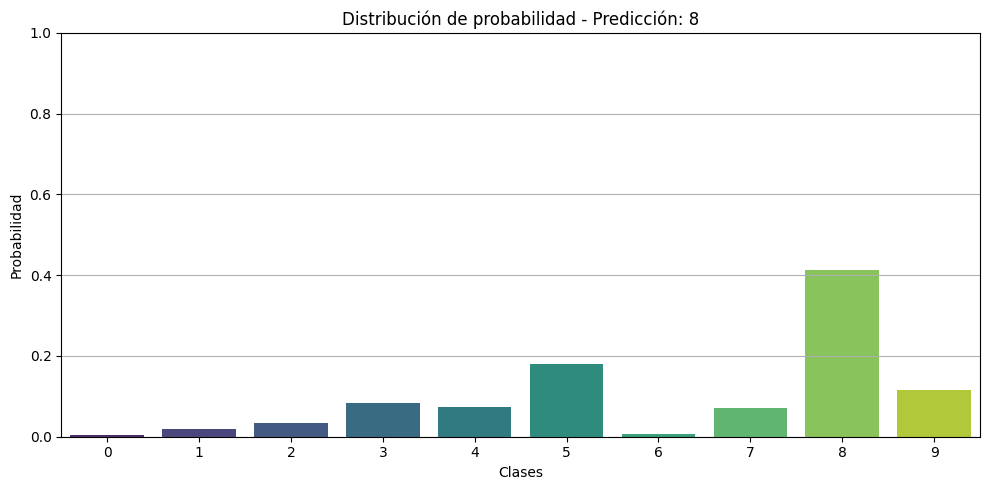

'8'

In [ ]:
predict_letter('/content/test/noise/5.png')

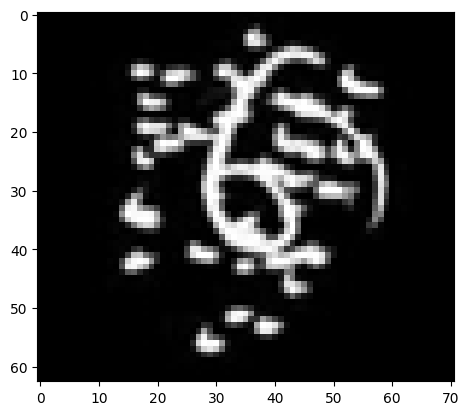

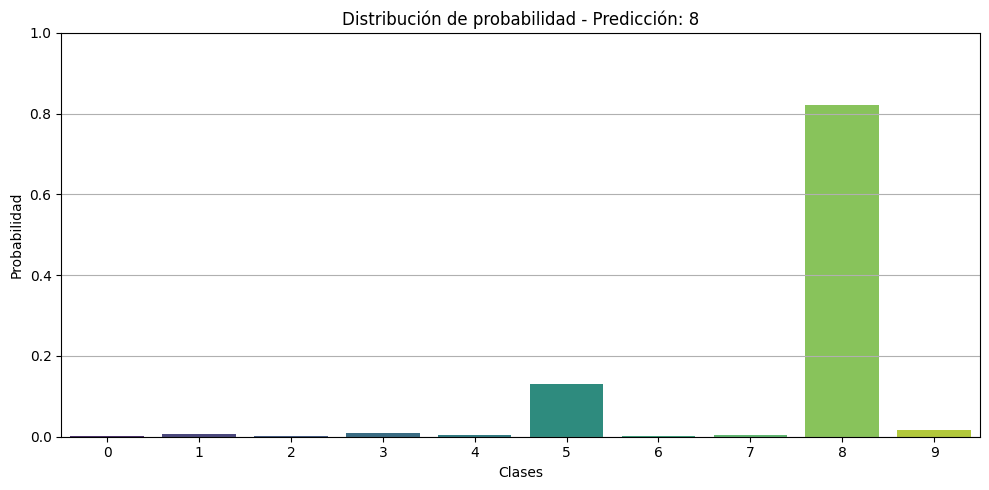

'8'

In [ ]:
predict_letter('/content/test/noise/6.png')

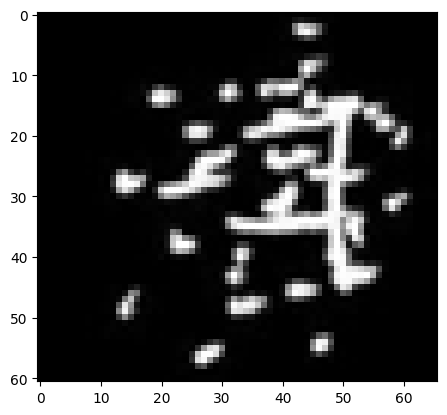

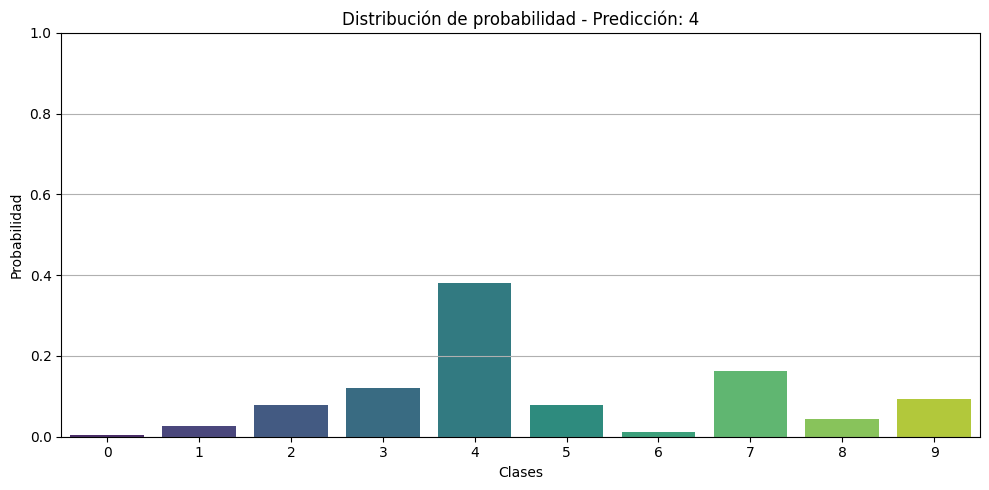

'4'

In [ ]:
predict_letter('/content/test/noise/7.png')

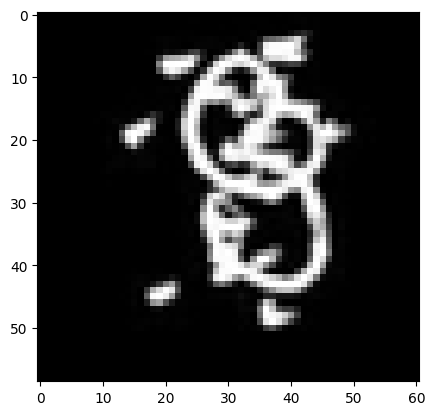

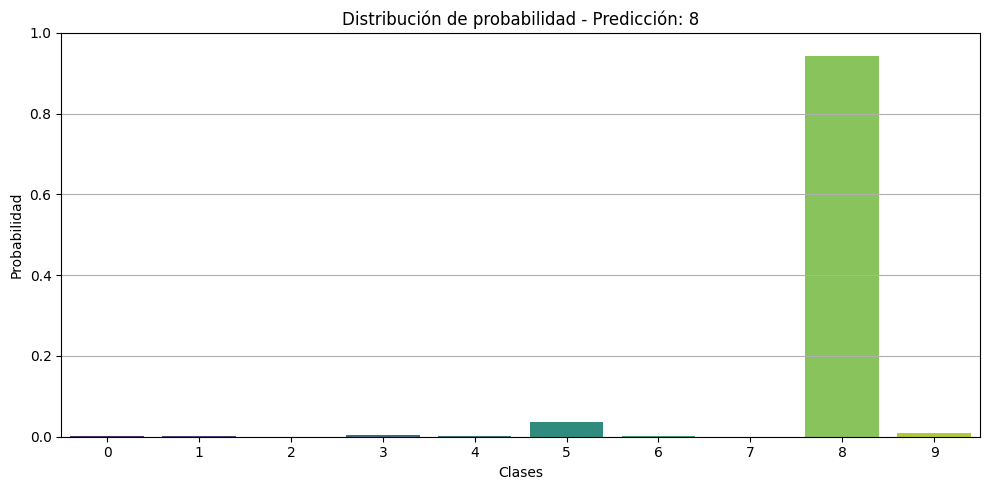

'8'

In [ ]:
predict_letter('/content/test/noise/8.png')

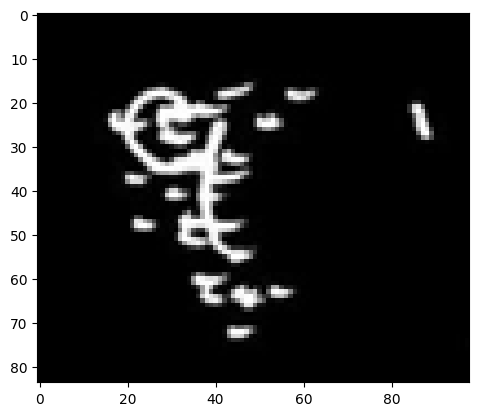

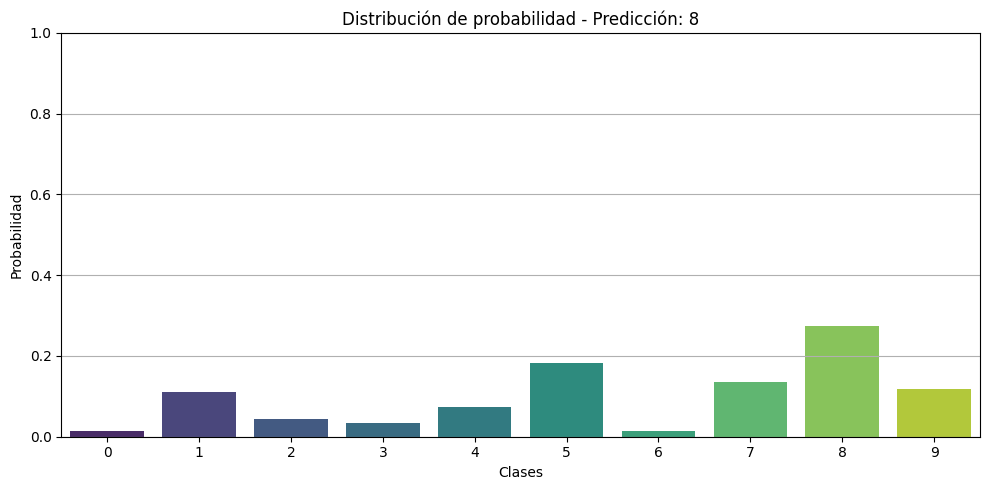

'8'

In [ ]:
predict_letter('/content/test/noise/9.png')

#Conclusión Ruido

El ruido visual tuvo un impacto considerable en la precisión del modelo. Esto se debe principalmente a que el ruido agregado suele superponerse directamente sobre los dígitos, ocultando características clave como curvas, bordes o trazos distintivos. En algunos casos, el ruido actúa como una mancha que distorsiona la forma del número, dificultando su interpretación. Como resultado, el modelo genera distribuciones de probabilidad muy disputadas, donde no hay una clase claramente dominante, lo que refleja la incertidumbre del modelo ante este tipo de interferencia.

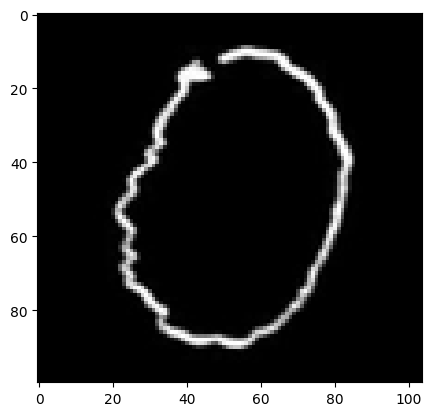

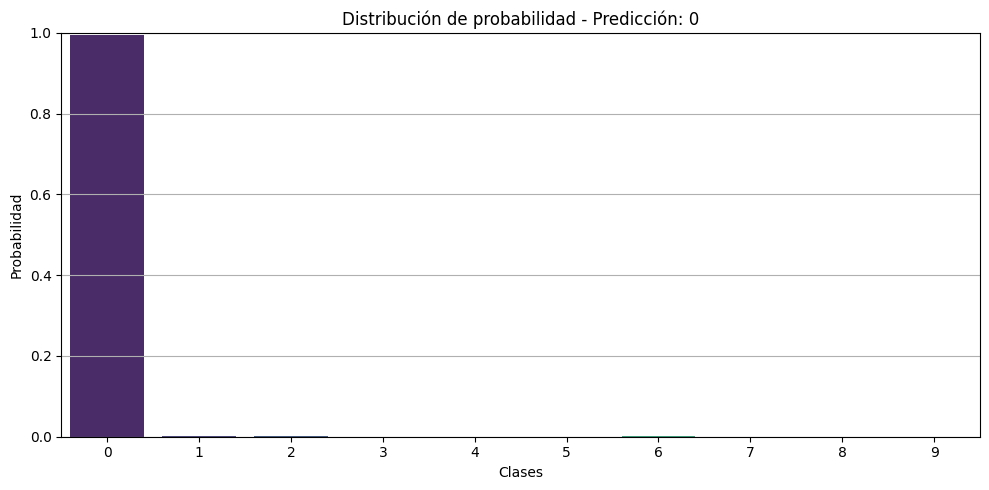

'0'

In [ ]:
predict_letter('/content/test/special/0.png')

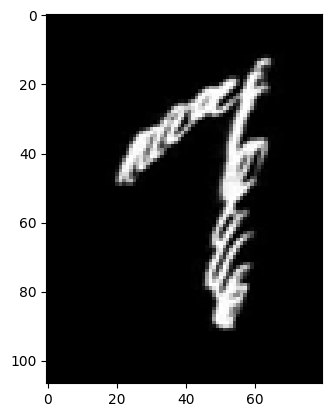

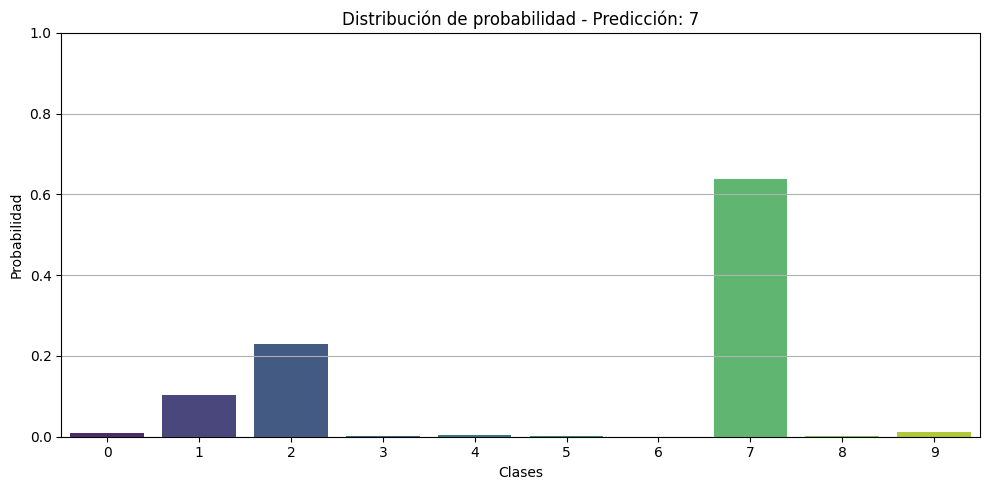

'7'

In [ ]:
predict_letter('/content/test/special/1.png')

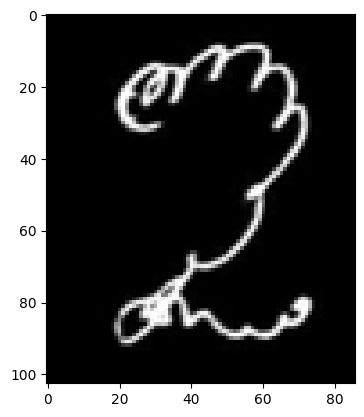

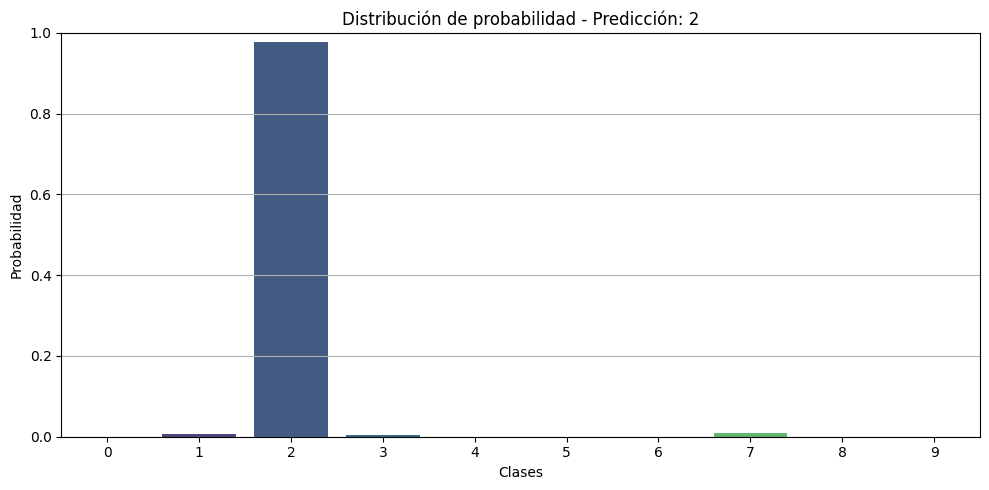

'2'

In [ ]:
predict_letter('/content/test/special/2.png')

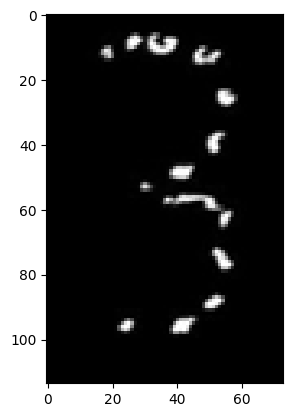

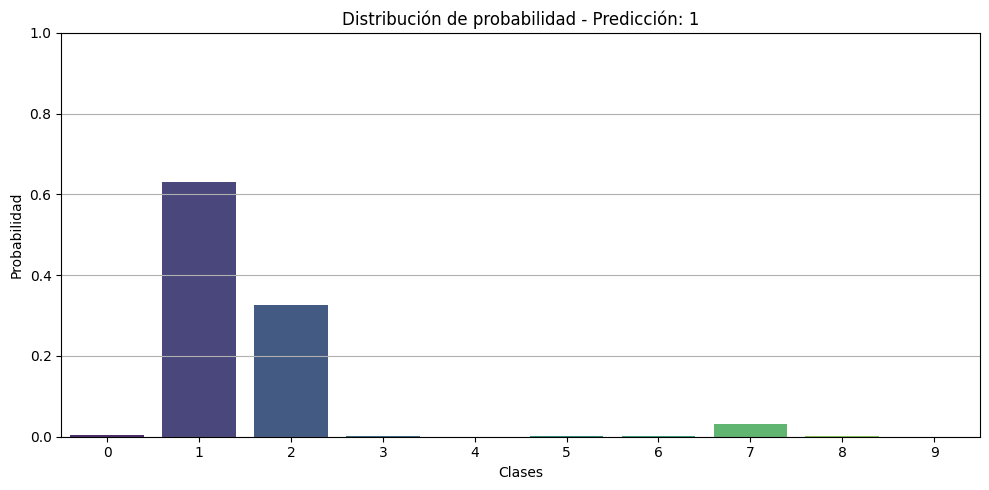

'1'

In [ ]:
predict_letter('/content/test/special/3.png')

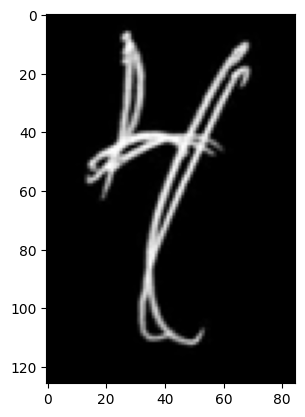

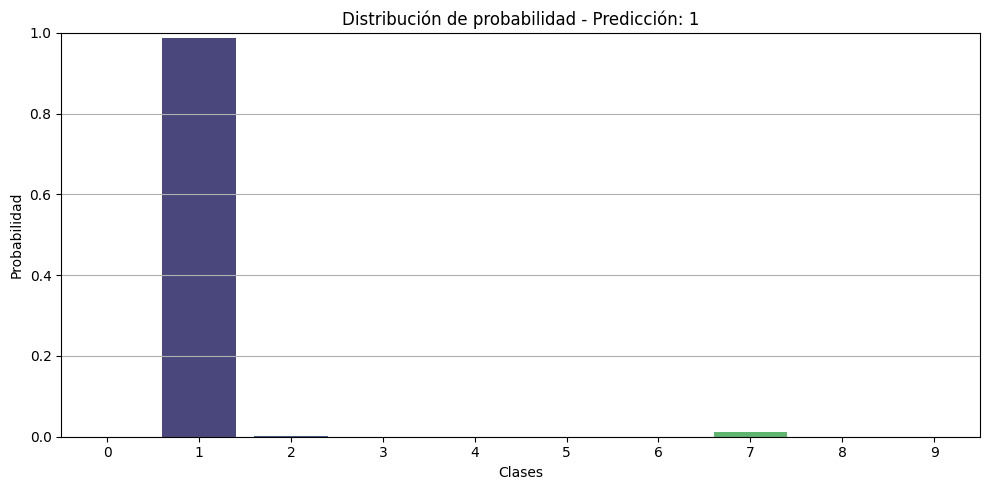

'1'

In [ ]:
predict_letter('/content/test/special/4.png')

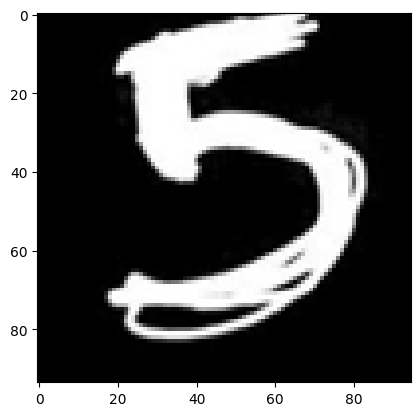

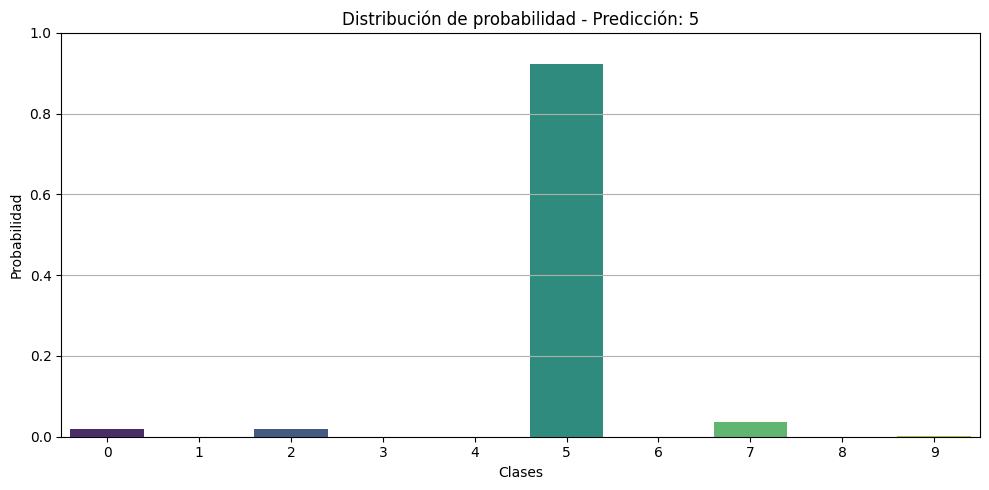

'5'

In [ ]:
predict_letter('/content/test/special/5.png')

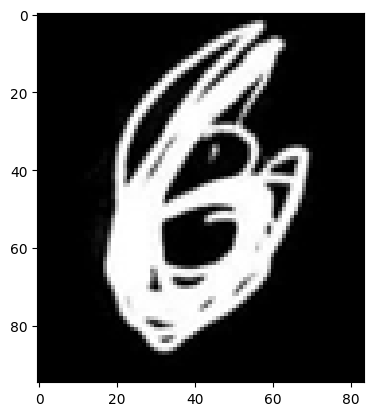

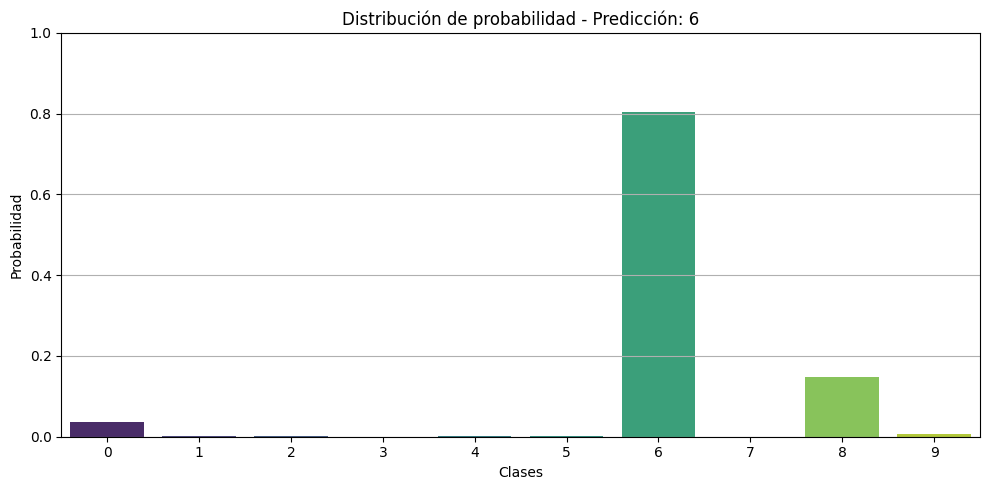

'6'

In [ ]:
predict_letter('/content/test/special/6.png')

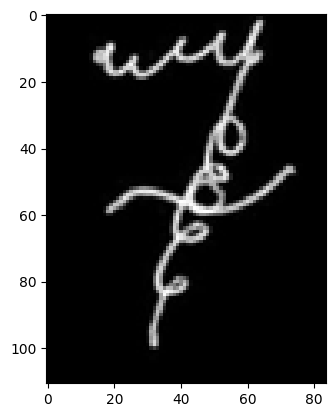

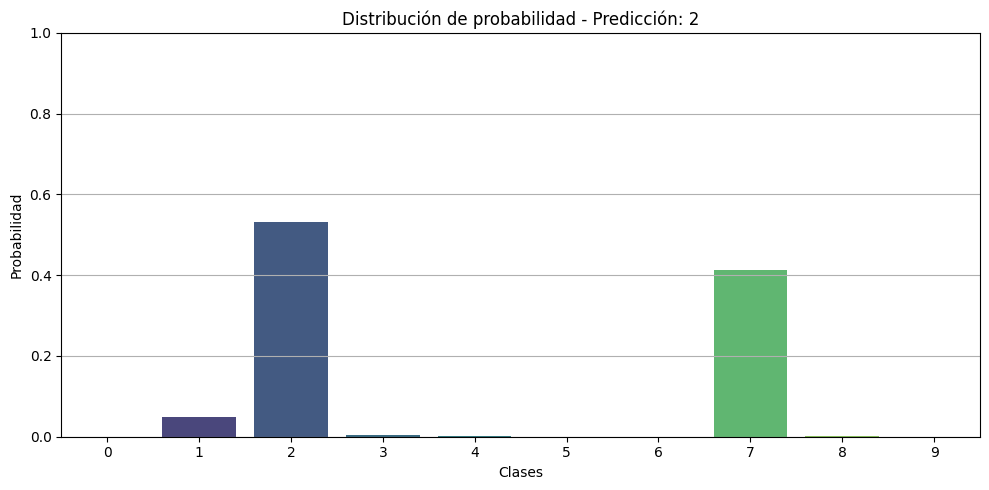

'2'

In [ ]:
predict_letter('/content/test/special/7.png')

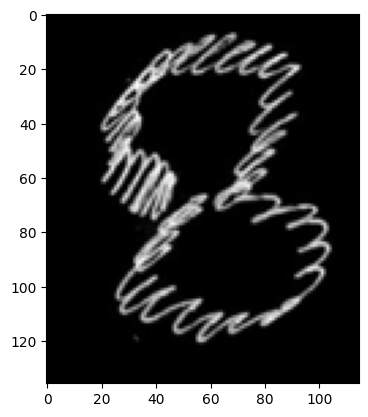

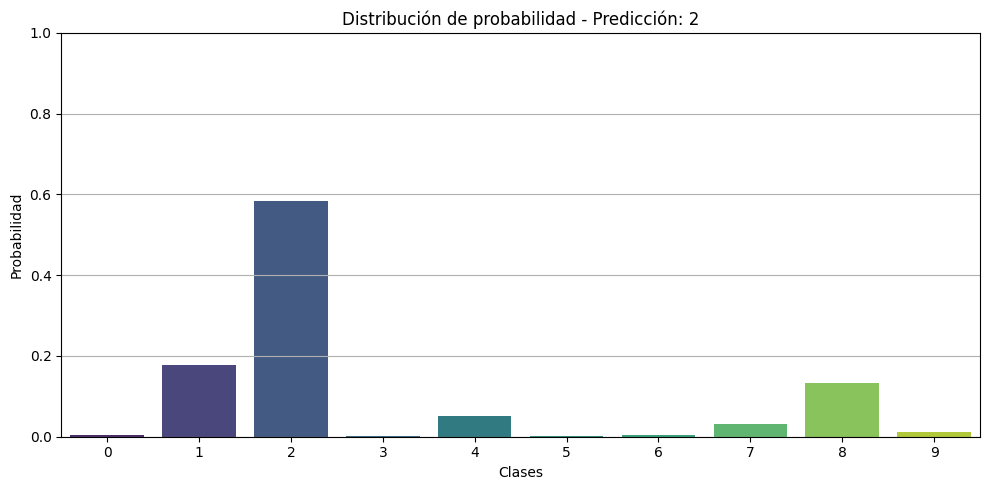

'2'

In [ ]:
predict_letter('/content/test/special/8.png')

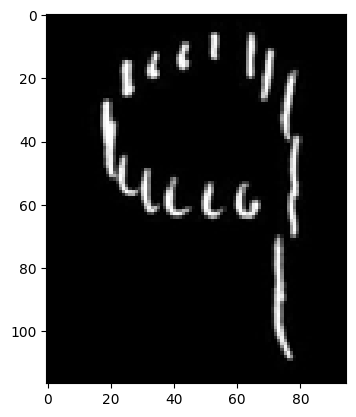

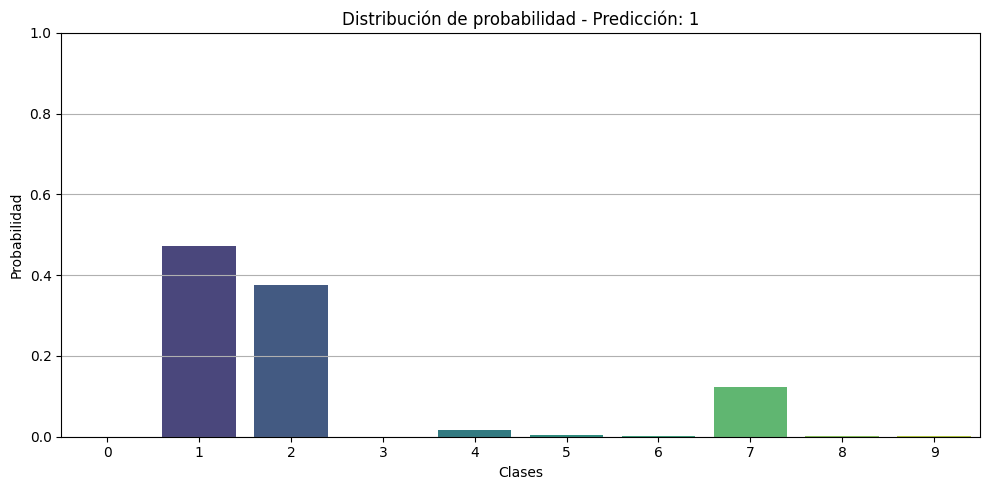

'1'

In [ ]:
predict_letter('/content/test/special/9.png')

##CONCLUSION ESPECIAL

Las imágenes especiales, debido a sus formas poco convencionales o patrones de líneas atípicos, afectan notablemente el desempeño del modelo. Aunque para un observador humano resulta relativamente sencillo identificar el dígito, el modelo no logra reconocerlos correctamente, lo que indica que depende de patrones visuales específicos aprendidos durante el entrenamiento y no generaliza bien ante estilos inusuales de escritura.

## 4b.5 Resumen
En resumen el ingreso de valores distintos a lo cotidiano, si afecta la precisión del modelo, lo cual sirve para poder medir el nivel de efectividad realista, quitando el perfeccionismo.
Y se debe realizar ajustes al modelo quias y asignar mas datos realistas para que el modelo pueda tomar en cuenta esos casos

# Preguntas

1. ¿Por qué es importante que las imágenes utilizadas para hacer predicciones tengan el mismo formato (dimensiones y color) que las imágenes con las que se entrenó el modelo?

  Es importante porque el modelo fue entrenado específicamente con imágenes de un solo canal (escala de grises) y con una resolución de 28x28 píxeles. Estas características definen la estructura de entrada del modelo.

2. Describe los pasos necesarios para procesar una imagen antes de hacer una predicción con el modelo entrenado. ¿Qué transformaciones se deben aplicar?

  Los pasos para procesar la imagen son:
  Resize : volver la imagen de tamaño m x n en una matriz de 28 x 28 en estos casos
  Greyscale : Poner la imagen en escala de grises ya que el modelo fue entrenado con imagenes de un solo canal y escala de grises es ese canal.
  Normalizar: normalizar los valores de 0 a 255 en 0 a 1.
  Batch: Se agrega dimensión adicional para simular que se trabaja con lotes de imagenes.

3. ¿Qué es la "dimensión del lote" (batch) y por qué es necesario agregarla cuando hacemos predicciones con el modelo?

  La dimensión del lote es una dimensión adicional que se utiliza para representar un grupo de imágenes que se procesan simultáneamente. Durante el entrenamiento, se utilizan lotes de imágenes para mejorar la eficiencia computacional.

4. ¿Cómo interpreta el modelo las predicciones que genera? Explica el formato de salida y cómo se convierte en un número.

  El modelo genera como salida un vector con 10 valores, cada uno representando la probabilidad de que la imagen corresponda a un dígito del 0 al 9. Estos valores se obtienen mediante la última capa del modelo, que generalmente es una capa totalmente conectada seguida de una función softmax. El valor más alto del vector indica la clase más probable.